In [1]:
# Just run this block. Please do not modify the following code.
import math
import time
import io
import numpy as np
import csv
from IPython.display import Image

# Pytorch package
import torch
import torch.nn as nn
import torch.optim as optim

# Torchtest package
# import torchtext
# from torchtext.datasets import Multi30k
from torch.utils.data import DataLoader
# from torchtext.data.utils import get_tokenizer
from collections import Counter
# from torchtext.vocab import vocab
# from torchtext.utils import download_from_url, extract_archive
from torch.nn.utils.rnn import pad_sequence
from torch.optim import Adam

# Tqdm progress bar
from tqdm import tqdm_notebook, tqdm

# Code provide to you for training and evaluation

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

torch.seed

<function torch.random.seed() -> int>

In [2]:
# Check device availability
device = ''
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
device = torch.device(device)
print("You are using device: %s" % device)

You are using device: mps


# Training, evaluation, and plotting loss curves

In [3]:
# Code provide to you for training and evaluation
from utils import train
from utils import plot_curves
from Model import Model


def train_and_plot(model, randomCNN, a_S, optimizer, scheduler, criterion, train_loader, filename, epochs, device='cpu', style_loss_param=10000):
    train_loss_history = []

    for epoch_idx in range(epochs):
        print("-----------------------------------")
        print("Epoch %d" % (epoch_idx+1))
        print("-----------------------------------")

        train_loss, avg_train_loss, train_total_losses = train(model, randomCNN, a_S, train_loader, optimizer, criterion, device=device, style_loss_param=style_loss_param)
        scheduler.step(train_loss)

        train_loss_history.append(avg_train_loss)

        print("Training Loss: %.4f. L1: %.4f. L2: %.4f. L3 (not used): %.4f. Style Loss: %.4f" % (avg_train_loss, train_total_losses[0], train_total_losses[1], train_total_losses[2], train_total_losses[3]))        

    plot_curves(train_loss_history, filename)


In [4]:
source_file = "examples/Joe Nichols.mp3" #'dataset/uvr-mdx-net-split/vocals_chunks/008  Nico & Vinz - Am I Wrong_(Vocals)_UVR-MDX-NET-Inst_HQ_3-chunk-11.mp3'
target_file = "examples/Avicii.mp3" #'dataset/uvr-mdx-net-split/vocals_chunks/073  Taylor Swift - Red_(Vocals)_UVR-MDX-NET-Inst_HQ_3-chunk-13.mp3'

In [6]:
# THIS MAY FAIL FIRST TIME, JUST RUN IT AGAIN

# import necessary libraries
from resemblyzer import preprocess_wav, VoiceEncoder
from  pathlib import Path 
from tqdm import tqdm 
import numpy as np 
from IPython.display import Audio 
from itertools import groupby
import heapq
import torchaudio as ta
from os import listdir
from os.path import isfile, join, basename
from  pathlib import Path 
import numpy as np
import torch
import librosa
import soundfile as sf

n_ftt = 510
win_length = n_ftt
hop_length = int(n_ftt / 2)

transform = ta.transforms.Spectrogram(n_ftt)


source = ta.load(source_file)
source_mono = torch.mean(source[0],0,False)
target = ta.load(target_file)
target_mono = torch.mean(target[0],0,False)
#print(mono.shape)

#print(f)
source_wav = preprocess_wav(source_file)
target_wav = preprocess_wav(target_file)
# print(wav)

#Get style encoding
encoder = VoiceEncoder()
source_embed = encoder.embed_utterance(source_wav)
target_embed = encoder.embed_utterance(target_wav)

# #Get Spectrogram
spec_source = transform(source_mono).unsqueeze(0)
spec_target = transform(target_mono).unsqueeze(0).unsqueeze(0).to(device)

# Get Sample Rate

_, samplerate_source = sf.read(source_file)
_, samplerate_target = sf.read(target_file)
if samplerate_source != samplerate_target:
    raise("Sample rates must be the same!")
samplerate = samplerate_source



/opt/homebrew/anaconda3/envs/cs7643-finalproject-v2/lib/python3.10/site-packages/resemblyzer/voice_encoder.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = 

Loaded the voice encoder model on cpu in 0.00 seconds.


In [7]:
print("Spec Source: ", spec_source.shape)
print("Spec Target: ", spec_target.shape)
print("Embed Source: ", source_embed.shape)
print("Embed Target: ", target_embed.shape)
print("SR: ", samplerate)

Spec Source:  torch.Size([1, 256, 1730])
Spec Target:  torch.Size([1, 1, 256, 1730])
Embed Source:  (256,)
Embed Target:  (256,)
SR:  44100


In [12]:
import numpy as np
# Example usage:
source_style = source_embed
target_style = target_embed

dataList = []

for i in range(0,spec_source.shape[0]):
    dataList.append((spec_source[i,:,:],target_style))

print(len(dataList))
print(len(dataList[0]))
print(dataList[0][0].shape)
print(dataList[0][1].shape)

1
2
torch.Size([256, 1730])
(256,)


In [13]:
from torch.autograd import Variable
from RandomCNN import RandomCNN

model = Model().to(device)

randomCNN = RandomCNN().to(device)
randomCNN.eval()

a_S_var = Variable(spec_target, requires_grad=False).float()
print(a_S_var.shape)
a_S = randomCNN(a_S_var)

torch.Size([1, 1, 256, 1730])


-----------------------------------
Epoch 1
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.80s/it, loss=1.92e+3]


Training Loss: 1919.6121. L1: 793.1991. L2: 793.2816. L3 (not used): 1045.4984. Style Loss: 333.1313
-----------------------------------
Epoch 2
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.66s/it, loss=1.92e+3]


Training Loss: 1916.2435. L1: 792.8471. L2: 790.6984. L3 (not used): 1242.3037. Style Loss: 332.6981
-----------------------------------
Epoch 3
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.91e+3]


Training Loss: 1911.7393. L1: 792.4167. L2: 787.8410. L3 (not used): 1080.6481. Style Loss: 331.4814
-----------------------------------
Epoch 4
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.91e+3]


Training Loss: 1906.3607. L1: 791.9467. L2: 785.2720. L3 (not used): 926.9768. Style Loss: 329.1420
-----------------------------------
Epoch 5
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.68s/it, loss=1.9e+3]


Training Loss: 1899.8057. L1: 791.4478. L2: 782.9926. L3 (not used): 865.8668. Style Loss: 325.3653
-----------------------------------
Epoch 6
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.89e+3]


Training Loss: 1891.7271. L1: 790.9197. L2: 781.0241. L3 (not used): 812.6769. Style Loss: 319.7832
-----------------------------------
Epoch 7
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.88e+3]


Training Loss: 1881.3613. L1: 790.3320. L2: 779.1663. L3 (not used): 767.4046. Style Loss: 311.8631
-----------------------------------
Epoch 8
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.87e+3]


Training Loss: 1867.8933. L1: 789.6649. L2: 777.3339. L3 (not used): 806.4598. Style Loss: 300.8946
-----------------------------------
Epoch 9
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.72s/it, loss=1.85e+3]


Training Loss: 1850.3757. L1: 788.9050. L2: 775.5142. L3 (not used): 817.3916. Style Loss: 285.9566
-----------------------------------
Epoch 10
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.66s/it, loss=1.83e+3]


Training Loss: 1827.6608. L1: 788.0292. L2: 773.6527. L3 (not used): 796.1615. Style Loss: 265.9788
-----------------------------------
Epoch 11
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.68s/it, loss=1.8e+3]


Training Loss: 1798.7163. L1: 787.0056. L2: 771.7443. L3 (not used): 792.0285. Style Loss: 239.9664
-----------------------------------
Epoch 12
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.66s/it, loss=1.76e+3]


Training Loss: 1763.4214. L1: 785.7994. L2: 769.7556. L3 (not used): 834.8425. Style Loss: 207.8665
-----------------------------------
Epoch 13
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.72e+3]


Training Loss: 1724.5220. L1: 784.3825. L2: 767.6174. L3 (not used): 863.2454. Style Loss: 172.5221
-----------------------------------
Epoch 14
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.69e+3]


Training Loss: 1691.0792. L1: 782.7682. L2: 765.3198. L3 (not used): 886.0167. Style Loss: 142.9912
-----------------------------------
Epoch 15
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.68e+3]


Training Loss: 1678.6252. L1: 781.1262. L2: 763.0110. L3 (not used): 898.2230. Style Loss: 134.4880
-----------------------------------
Epoch 16
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.68e+3]


Training Loss: 1681.0200. L1: 780.0881. L2: 761.2875. L3 (not used): 919.4660. Style Loss: 139.6445
-----------------------------------
Epoch 17
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.67e+3]


Training Loss: 1670.1377. L1: 779.9188. L2: 760.4431. L3 (not used): 959.4943. Style Loss: 129.7758
-----------------------------------
Epoch 18
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.65e+3]


Training Loss: 1650.7589. L1: 780.2902. L2: 760.0938. L3 (not used): 1007.7850. Style Loss: 110.3749
-----------------------------------
Epoch 19
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.64e+3]


Training Loss: 1636.1758. L1: 780.9133. L2: 759.9777. L3 (not used): 1055.0395. Style Loss: 95.2848
-----------------------------------
Epoch 20
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.63e+3]


Training Loss: 1630.6158. L1: 781.5820. L2: 759.8896. L3 (not used): 1113.5972. Style Loss: 89.1441
-----------------------------------
Epoch 21
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.63e+3]


Training Loss: 1631.2418. L1: 782.1605. L2: 759.7061. L3 (not used): 1146.0084. Style Loss: 89.3751
-----------------------------------
Epoch 22
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.63e+3]


Training Loss: 1633.8657. L1: 782.5814. L2: 759.3165. L3 (not used): 1154.9869. Style Loss: 91.9678
-----------------------------------
Epoch 23
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.64e+3]


Training Loss: 1635.8730. L1: 782.8295. L2: 758.7229. L3 (not used): 1155.5452. Style Loss: 94.3205
-----------------------------------
Epoch 24
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.64e+3]


Training Loss: 1636.2817. L1: 782.9180. L2: 757.9218. L3 (not used): 1155.7290. Style Loss: 95.4419
-----------------------------------
Epoch 25
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.64e+3]


Training Loss: 1635.1953. L1: 782.8723. L2: 756.9740. L3 (not used): 1142.2904. Style Loss: 95.3491
-----------------------------------
Epoch 26
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.63e+3]


Training Loss: 1633.1124. L1: 782.7251. L2: 755.9070. L3 (not used): 1107.4794. Style Loss: 94.4804
-----------------------------------
Epoch 27
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.63e+3]


Training Loss: 1630.5490. L1: 782.5129. L2: 754.7509. L3 (not used): 1090.4670. Style Loss: 93.2850
-----------------------------------
Epoch 28
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.63e+3]


Training Loss: 1627.8446. L1: 782.2722. L2: 753.5673. L3 (not used): 1080.9404. Style Loss: 92.0050
-----------------------------------
Epoch 29
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.67s/it, loss=1.63e+3]


Training Loss: 1625.1327. L1: 782.0367. L2: 752.3978. L3 (not used): 1087.9852. Style Loss: 90.6981
-----------------------------------
Epoch 30
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.71s/it, loss=1.62e+3]


Training Loss: 1622.3956. L1: 781.8329. L2: 751.2621. L3 (not used): 1088.6206. Style Loss: 89.3007
-----------------------------------
Epoch 31
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.66s/it, loss=1.62e+3]


Training Loss: 1619.6458. L1: 781.6762. L2: 750.1682. L3 (not used): 1085.9280. Style Loss: 87.8013
-----------------------------------
Epoch 32
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.62e+3]


Training Loss: 1617.0282. L1: 781.5704. L2: 749.1278. L3 (not used): 1077.0203. Style Loss: 86.3300
-----------------------------------
Epoch 33
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.66s/it, loss=1.61e+3]


Training Loss: 1614.7626. L1: 781.5103. L2: 748.1584. L3 (not used): 1083.9894. Style Loss: 85.0939
-----------------------------------
Epoch 34
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.66s/it, loss=1.61e+3]


Training Loss: 1613.0552. L1: 781.4833. L2: 747.3094. L3 (not used): 1054.5609. Style Loss: 84.2625
-----------------------------------
Epoch 35
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.68s/it, loss=1.61e+3]


Training Loss: 1612.0264. L1: 781.4774. L2: 746.6642. L3 (not used): 1119.2048. Style Loss: 83.8848
-----------------------------------
Epoch 36
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.61e+3]


Training Loss: 1610.7188. L1: 781.4762. L2: 745.3813. L3 (not used): 1084.2653. Style Loss: 83.8612
-----------------------------------
Epoch 37
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.61e+3]


Training Loss: 1610.2673. L1: 781.4710. L2: 744.7531. L3 (not used): 1084.9155. Style Loss: 84.0432
-----------------------------------
Epoch 38
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.61e+3]


Training Loss: 1609.7577. L1: 781.4564. L2: 744.0559. L3 (not used): 1128.6376. Style Loss: 84.2453
-----------------------------------
Epoch 39
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.66s/it, loss=1.61e+3]


Training Loss: 1608.6630. L1: 781.4260. L2: 742.8601. L3 (not used): 1123.5879. Style Loss: 84.3768
-----------------------------------
Epoch 40
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.68s/it, loss=1.61e+3]


Training Loss: 1607.9486. L1: 781.3806. L2: 742.1754. L3 (not used): 1097.5509. Style Loss: 84.3927
-----------------------------------
Epoch 41
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.69s/it, loss=1.61e+3]


Training Loss: 1606.5370. L1: 781.3260. L2: 740.9540. L3 (not used): 1106.8650. Style Loss: 84.2570
-----------------------------------
Epoch 42
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.68s/it, loss=1.61e+3]


Training Loss: 1605.5244. L1: 781.2649. L2: 740.2201. L3 (not used): 1128.0119. Style Loss: 84.0395
-----------------------------------
Epoch 43
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.66s/it, loss=1.6e+3]


Training Loss: 1604.1141. L1: 781.2015. L2: 739.1531. L3 (not used): 1103.8052. Style Loss: 83.7596
-----------------------------------
Epoch 44
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.6e+3]


Training Loss: 1602.9720. L1: 781.1429. L2: 738.3438. L3 (not used): 1061.2687. Style Loss: 83.4853
-----------------------------------
Epoch 45
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.6e+3]


Training Loss: 1601.7024. L1: 781.0964. L2: 737.3787. L3 (not used): 1061.5583. Style Loss: 83.2273
-----------------------------------
Epoch 46
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.6e+3]


Training Loss: 1600.6569. L1: 781.0651. L2: 736.6062. L3 (not used): 1096.7503. Style Loss: 82.9856
-----------------------------------
Epoch 47
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.76s/it, loss=1.6e+3]


Training Loss: 1599.4387. L1: 781.0496. L2: 735.6590. L3 (not used): 1050.0313. Style Loss: 82.7303
-----------------------------------
Epoch 48
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.66s/it, loss=1.6e+3]


Training Loss: 1598.4557. L1: 781.0490. L2: 734.9373. L3 (not used): 1046.1304. Style Loss: 82.4694
-----------------------------------
Epoch 49
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.6e+3]


Training Loss: 1597.2389. L1: 781.0613. L2: 733.9833. L3 (not used): 1058.8738. Style Loss: 82.1943
-----------------------------------
Epoch 50
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.6e+3]


Training Loss: 1596.3286. L1: 781.0810. L2: 733.3279. L3 (not used): 1090.6217. Style Loss: 81.9197
-----------------------------------
Epoch 51
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.67s/it, loss=1.6e+3]


Training Loss: 1595.1753. L1: 781.1016. L2: 732.4129. L3 (not used): 1064.1973. Style Loss: 81.6609
-----------------------------------
Epoch 52
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.59e+3]


Training Loss: 1594.3457. L1: 781.1157. L2: 731.7946. L3 (not used): 1018.4547. Style Loss: 81.4354
-----------------------------------
Epoch 53
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.59e+3]


Training Loss: 1593.3892. L1: 781.1193. L2: 731.0417. L3 (not used): 1058.6147. Style Loss: 81.2282
-----------------------------------
Epoch 54
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.59e+3]


Training Loss: 1593.0167. L1: 781.1091. L2: 730.8627. L3 (not used): 1020.6950. Style Loss: 81.0450
-----------------------------------
Epoch 55
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.66s/it, loss=1.59e+3]


Training Loss: 1592.7749. L1: 781.0844. L2: 730.8079. L3 (not used): 1094.4513. Style Loss: 80.8827
-----------------------------------
Epoch 56
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.69s/it, loss=1591.25]


Training Loss: 1591.2500. L1: 781.0455. L2: 729.5034. L3 (not used): 1060.0139. Style Loss: 80.7012
-----------------------------------
Epoch 57
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.68s/it, loss=1.59e+3]


Training Loss: 1590.1377. L1: 780.9932. L2: 728.5897. L3 (not used): 1022.2847. Style Loss: 80.5548
-----------------------------------
Epoch 58
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.66s/it, loss=1.59e+3]


Training Loss: 1588.9976. L1: 780.9294. L2: 727.6718. L3 (not used): 1014.4249. Style Loss: 80.3965
-----------------------------------
Epoch 59
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.59e+3]


Training Loss: 1587.8297. L1: 780.8616. L2: 726.7235. L3 (not used): 1039.7363. Style Loss: 80.2446
-----------------------------------
Epoch 60
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.59e+3]


Training Loss: 1586.9399. L1: 780.7972. L2: 726.0543. L3 (not used): 1051.6280. Style Loss: 80.0885
-----------------------------------
Epoch 61
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.59e+3]


Training Loss: 1585.6821. L1: 780.7375. L2: 725.0340. L3 (not used): 1039.1923. Style Loss: 79.9106
-----------------------------------
Epoch 62
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.58e+3]


Training Loss: 1584.6630. L1: 780.6832. L2: 724.2563. L3 (not used): 1016.3237. Style Loss: 79.7235
-----------------------------------
Epoch 63
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.66s/it, loss=1.58e+3]


Training Loss: 1583.6974. L1: 780.6366. L2: 723.5703. L3 (not used): 1017.8991. Style Loss: 79.4905
-----------------------------------
Epoch 64
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.58e+3]


Training Loss: 1582.4700. L1: 780.5988. L2: 722.6443. L3 (not used): 997.6941. Style Loss: 79.2267
-----------------------------------
Epoch 65
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.58e+3]


Training Loss: 1581.5774. L1: 780.5653. L2: 722.0681. L3 (not used): 1034.4480. Style Loss: 78.9440
-----------------------------------
Epoch 66
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.58e+3]


Training Loss: 1580.3770. L1: 780.5324. L2: 721.2081. L3 (not used): 1041.3190. Style Loss: 78.6364
-----------------------------------
Epoch 67
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.68s/it, loss=1.58e+3]


Training Loss: 1579.2009. L1: 780.4983. L2: 720.3739. L3 (not used): 1009.1598. Style Loss: 78.3287
-----------------------------------
Epoch 68
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.58e+3]


Training Loss: 1578.2585. L1: 780.4604. L2: 719.7957. L3 (not used): 998.8250. Style Loss: 78.0024
-----------------------------------
Epoch 69
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.58e+3]


Training Loss: 1576.9989. L1: 780.4155. L2: 718.9382. L3 (not used): 1018.9009. Style Loss: 77.6452
-----------------------------------
Epoch 70
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.58e+3]


Training Loss: 1575.8552. L1: 780.3622. L2: 718.2172. L3 (not used): 1042.7645. Style Loss: 77.2759
-----------------------------------
Epoch 71
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.57e+3]


Training Loss: 1574.7588. L1: 780.3011. L2: 717.5654. L3 (not used): 1026.0645. Style Loss: 76.8924
-----------------------------------
Epoch 72
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.66s/it, loss=1.57e+3]


Training Loss: 1573.4584. L1: 780.2357. L2: 716.7313. L3 (not used): 994.8277. Style Loss: 76.4914
-----------------------------------
Epoch 73
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.67s/it, loss=1.57e+3]


Training Loss: 1572.2588. L1: 780.1677. L2: 716.0226. L3 (not used): 997.5185. Style Loss: 76.0686
-----------------------------------
Epoch 74
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.57e+3]


Training Loss: 1571.1331. L1: 780.0997. L2: 715.4055. L3 (not used): 994.0593. Style Loss: 75.6280
-----------------------------------
Epoch 75
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.57e+3]


Training Loss: 1569.7653. L1: 780.0298. L2: 714.5595. L3 (not used): 995.9870. Style Loss: 75.1759
-----------------------------------
Epoch 76
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.69s/it, loss=1.57e+3]


Training Loss: 1568.7277. L1: 779.9646. L2: 714.0673. L3 (not used): 1023.0980. Style Loss: 74.6957
-----------------------------------
Epoch 77
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.57e+3]


Training Loss: 1568.1580. L1: 779.9037. L2: 714.0673. L3 (not used): 1016.4146. Style Loss: 74.1871
-----------------------------------
Epoch 78
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.66s/it, loss=1.57e+3]


Training Loss: 1568.3047. L1: 779.8477. L2: 714.7586. L3 (not used): 1062.0330. Style Loss: 73.6984
-----------------------------------
Epoch 79
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.70s/it, loss=1.57e+3]


Training Loss: 1566.8922. L1: 779.7909. L2: 713.8848. L3 (not used): 991.4876. Style Loss: 73.2166
-----------------------------------
Epoch 80
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.57e+3]


Training Loss: 1566.6827. L1: 779.7337. L2: 714.1801. L3 (not used): 1084.3392. Style Loss: 72.7689
-----------------------------------
Epoch 81
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.56e+3]


Training Loss: 1564.3312. L1: 779.6830. L2: 712.3401. L3 (not used): 1038.2574. Style Loss: 72.3081
-----------------------------------
Epoch 82
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.56e+3]


Training Loss: 1562.7037. L1: 779.6307. L2: 711.1799. L3 (not used): 1037.1970. Style Loss: 71.8931
-----------------------------------
Epoch 83
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.56e+3]


Training Loss: 1562.0859. L1: 779.5713. L2: 711.0790. L3 (not used): 1028.5956. Style Loss: 71.4355
-----------------------------------
Epoch 84
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.56e+3]


Training Loss: 1559.8562. L1: 779.5112. L2: 709.4025. L3 (not used): 1024.7136. Style Loss: 70.9426
-----------------------------------
Epoch 85
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.56e+3]


Training Loss: 1559.2122. L1: 779.4527. L2: 709.2706. L3 (not used): 1061.0357. Style Loss: 70.4887
-----------------------------------
Epoch 86
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.56e+3]


Training Loss: 1557.8575. L1: 779.3937. L2: 708.4371. L3 (not used): 1070.8182. Style Loss: 70.0268
-----------------------------------
Epoch 87
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.66s/it, loss=1.56e+3]


Training Loss: 1556.0588. L1: 779.3306. L2: 707.1892. L3 (not used): 1045.0301. Style Loss: 69.5390
-----------------------------------
Epoch 88
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.56e+3]


Training Loss: 1555.6038. L1: 779.2656. L2: 707.2961. L3 (not used): 1031.8084. Style Loss: 69.0422
-----------------------------------
Epoch 89
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.55e+3]


Training Loss: 1553.6562. L1: 779.2061. L2: 705.9373. L3 (not used): 1041.2280. Style Loss: 68.5129
-----------------------------------
Epoch 90
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.55e+3]


Training Loss: 1552.5046. L1: 779.1474. L2: 705.3957. L3 (not used): 1072.2244. Style Loss: 67.9616
-----------------------------------
Epoch 91
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.55e+3]


Training Loss: 1551.4758. L1: 779.0886. L2: 704.9874. L3 (not used): 1083.7641. Style Loss: 67.3999
-----------------------------------
Epoch 92
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.55e+3]


Training Loss: 1549.8900. L1: 779.0311. L2: 704.0429. L3 (not used): 1049.5570. Style Loss: 66.8160
-----------------------------------
Epoch 93
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.55e+3]


Training Loss: 1548.5439. L1: 778.9739. L2: 703.3598. L3 (not used): 1023.9617. Style Loss: 66.2102
-----------------------------------
Epoch 94
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.67s/it, loss=1.55e+3]


Training Loss: 1547.3989. L1: 778.9158. L2: 702.9042. L3 (not used): 1003.9463. Style Loss: 65.5788
-----------------------------------
Epoch 95
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.66s/it, loss=1.55e+3]


Training Loss: 1545.8849. L1: 778.8569. L2: 702.1083. L3 (not used): 1017.6753. Style Loss: 64.9197
-----------------------------------
Epoch 96
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.54e+3]


Training Loss: 1544.5635. L1: 778.7953. L2: 701.5109. L3 (not used): 1031.4745. Style Loss: 64.2573
-----------------------------------
Epoch 97
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.54e+3]


Training Loss: 1543.1641. L1: 778.7366. L2: 700.8533. L3 (not used): 1054.6454. Style Loss: 63.5741
-----------------------------------
Epoch 98
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.67s/it, loss=1.54e+3]


Training Loss: 1541.7081. L1: 778.6777. L2: 700.1722. L3 (not used): 1048.2281. Style Loss: 62.8583
-----------------------------------
Epoch 99
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.54e+3]


Training Loss: 1540.3484. L1: 778.6201. L2: 699.6137. L3 (not used): 1022.1364. Style Loss: 62.1147
-----------------------------------
Epoch 100
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.54e+3]


Training Loss: 1538.8359. L1: 778.5661. L2: 698.9265. L3 (not used): 1039.6566. Style Loss: 61.3434
-----------------------------------
Epoch 101
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.54e+3]


Training Loss: 1537.4001. L1: 778.5131. L2: 698.3475. L3 (not used): 1066.6792. Style Loss: 60.5395
-----------------------------------
Epoch 102
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.54e+3]


Training Loss: 1535.9773. L1: 778.4615. L2: 697.8365. L3 (not used): 1048.8512. Style Loss: 59.6792
-----------------------------------
Epoch 103
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.54e+3]


Training Loss: 1535.4897. L1: 778.4120. L2: 698.2839. L3 (not used): 1011.0581. Style Loss: 58.7938
-----------------------------------
Epoch 104
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.54e+3]


Training Loss: 1539.4500. L1: 778.3771. L2: 703.1332. L3 (not used): 1006.5750. Style Loss: 57.9397
-----------------------------------
Epoch 105
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.53e+3]


Training Loss: 1533.9849. L1: 778.3325. L2: 698.5415. L3 (not used): 1028.5366. Style Loss: 57.1108
-----------------------------------
Epoch 106
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.53e+3]


Training Loss: 1532.6082. L1: 778.2801. L2: 698.0579. L3 (not used): 1090.7981. Style Loss: 56.2702
-----------------------------------
Epoch 107
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.53e+3]


Training Loss: 1531.7513. L1: 778.2358. L2: 698.0758. L3 (not used): 1029.0302. Style Loss: 55.4397
-----------------------------------
Epoch 108
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.53e+3]


Training Loss: 1528.7438. L1: 778.2123. L2: 695.9501. L3 (not used): 988.6871. Style Loss: 54.5814
-----------------------------------
Epoch 109
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.66s/it, loss=1.53e+3]


Training Loss: 1527.5391. L1: 778.1970. L2: 695.5980. L3 (not used): 972.8178. Style Loss: 53.7441
-----------------------------------
Epoch 110
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.53e+3]


Training Loss: 1526.1863. L1: 778.1769. L2: 695.1880. L3 (not used): 976.5714. Style Loss: 52.8213
-----------------------------------
Epoch 111
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.52e+3]


Training Loss: 1524.2560. L1: 778.1488. L2: 694.3173. L3 (not used): 975.6740. Style Loss: 51.7899
-----------------------------------
Epoch 112
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.52e+3]


Training Loss: 1522.3375. L1: 778.1194. L2: 693.4855. L3 (not used): 963.6315. Style Loss: 50.7325
-----------------------------------
Epoch 113
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.52e+3]


Training Loss: 1520.3307. L1: 778.0930. L2: 692.5595. L3 (not used): 997.0113. Style Loss: 49.6781
-----------------------------------
Epoch 114
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.52e+3]


Training Loss: 1518.9464. L1: 778.0690. L2: 692.2534. L3 (not used): 1031.4645. Style Loss: 48.6240
-----------------------------------
Epoch 115
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.52e+3]


Training Loss: 1517.2476. L1: 778.0475. L2: 691.6290. L3 (not used): 1021.1724. Style Loss: 47.5710
-----------------------------------
Epoch 116
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.52e+3]


Training Loss: 1515.4873. L1: 778.0278. L2: 690.9290. L3 (not used): 1003.8527. Style Loss: 46.5306
-----------------------------------
Epoch 117
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.51e+3]


Training Loss: 1513.7787. L1: 778.0055. L2: 690.2585. L3 (not used): 978.2804. Style Loss: 45.5148
-----------------------------------
Epoch 118
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.51e+3]


Training Loss: 1512.2753. L1: 777.9788. L2: 689.7636. L3 (not used): 924.0250. Style Loss: 44.5328
-----------------------------------
Epoch 119
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.51e+3]


Training Loss: 1510.6267. L1: 777.9520. L2: 689.1000. L3 (not used): 886.4790. Style Loss: 43.5748
-----------------------------------
Epoch 120
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.66s/it, loss=1.51e+3]


Training Loss: 1509.0046. L1: 777.9304. L2: 688.4318. L3 (not used): 897.7322. Style Loss: 42.6426
-----------------------------------
Epoch 121
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.51e+3]


Training Loss: 1507.5291. L1: 777.9152. L2: 687.8802. L3 (not used): 938.5261. Style Loss: 41.7337
-----------------------------------
Epoch 122
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.51e+3]


Training Loss: 1506.0750. L1: 777.9068. L2: 687.3363. L3 (not used): 911.9330. Style Loss: 40.8318
-----------------------------------
Epoch 123
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.5e+3]


Training Loss: 1504.6359. L1: 777.9037. L2: 686.7803. L3 (not used): 900.9514. Style Loss: 39.9518
-----------------------------------
Epoch 124
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.5e+3]


Training Loss: 1503.1749. L1: 777.9007. L2: 686.1638. L3 (not used): 934.4239. Style Loss: 39.1105
-----------------------------------
Epoch 125
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.5e+3]


Training Loss: 1501.8405. L1: 777.8945. L2: 685.6420. L3 (not used): 923.5089. Style Loss: 38.3040
-----------------------------------
Epoch 126
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.5e+3]


Training Loss: 1500.4651. L1: 777.8880. L2: 685.0391. L3 (not used): 891.5581. Style Loss: 37.5380
-----------------------------------
Epoch 127
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.5e+3]


Training Loss: 1499.1870. L1: 777.8770. L2: 684.4984. L3 (not used): 896.5173. Style Loss: 36.8116
-----------------------------------
Epoch 128
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.5e+3]


Training Loss: 1497.9950. L1: 777.8625. L2: 684.0034. L3 (not used): 926.8559. Style Loss: 36.1292
-----------------------------------
Epoch 129
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.5e+3]


Training Loss: 1496.8972. L1: 777.8499. L2: 683.5497. L3 (not used): 946.6965. Style Loss: 35.4975
-----------------------------------
Epoch 130
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.5e+3]


Training Loss: 1495.9896. L1: 777.8375. L2: 683.2571. L3 (not used): 908.9059. Style Loss: 34.8950
-----------------------------------
Epoch 131
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.66s/it, loss=1.5e+3]


Training Loss: 1495.5941. L1: 777.8279. L2: 683.4144. L3 (not used): 935.9352. Style Loss: 34.3518
-----------------------------------
Epoch 132
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.5e+3]


Training Loss: 1495.8124. L1: 777.8181. L2: 684.1607. L3 (not used): 873.1127. Style Loss: 33.8336
-----------------------------------
Epoch 133
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.66s/it, loss=1.49e+3]


Training Loss: 1493.0215. L1: 777.8102. L2: 681.8341. L3 (not used): 899.9990. Style Loss: 33.3772
-----------------------------------
Epoch 134
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.49e+3]


Training Loss: 1492.9316. L1: 777.8008. L2: 682.1680. L3 (not used): 884.2192. Style Loss: 32.9629
-----------------------------------
Epoch 135
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.49e+3]


Training Loss: 1491.3868. L1: 777.7946. L2: 681.0423. L3 (not used): 893.6796. Style Loss: 32.5499
-----------------------------------
Epoch 136
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.49e+3]


Training Loss: 1490.8774. L1: 777.7915. L2: 680.9108. L3 (not used): 957.9138. Style Loss: 32.1751
-----------------------------------
Epoch 137
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.49e+3]


Training Loss: 1489.7323. L1: 777.7813. L2: 680.1176. L3 (not used): 935.3337. Style Loss: 31.8333
-----------------------------------
Epoch 138
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.49e+3]


Training Loss: 1488.5715. L1: 777.7665. L2: 679.2834. L3 (not used): 889.8374. Style Loss: 31.5217
-----------------------------------
Epoch 139
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.49e+3]


Training Loss: 1487.9810. L1: 777.7548. L2: 679.0064. L3 (not used): 865.4498. Style Loss: 31.2197
-----------------------------------
Epoch 140
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.49e+3]


Training Loss: 1486.8160. L1: 777.7433. L2: 678.1649. L3 (not used): 888.3779. Style Loss: 30.9078
-----------------------------------
Epoch 141
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.66s/it, loss=1.49e+3]


Training Loss: 1486.2471. L1: 777.7257. L2: 677.9015. L3 (not used): 881.4487. Style Loss: 30.6199
-----------------------------------
Epoch 142
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.67s/it, loss=1.49e+3]


Training Loss: 1485.2163. L1: 777.7014. L2: 677.1525. L3 (not used): 935.9691. Style Loss: 30.3625
-----------------------------------
Epoch 143
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.48e+3]


Training Loss: 1484.3610. L1: 777.6728. L2: 676.5563. L3 (not used): 904.9673. Style Loss: 30.1319
-----------------------------------
Epoch 144
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.48e+3]


Training Loss: 1483.7983. L1: 777.6476. L2: 676.2559. L3 (not used): 862.1892. Style Loss: 29.8948
-----------------------------------
Epoch 145
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.48e+3]


Training Loss: 1482.7117. L1: 777.6319. L2: 675.4497. L3 (not used): 879.9237. Style Loss: 29.6302
-----------------------------------
Epoch 146
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.48e+3]


Training Loss: 1482.0684. L1: 777.6169. L2: 675.0745. L3 (not used): 892.7227. Style Loss: 29.3770
-----------------------------------
Epoch 147
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.48e+3]


Training Loss: 1481.3217. L1: 777.5948. L2: 674.5728. L3 (not used): 846.5905. Style Loss: 29.1540
-----------------------------------
Epoch 148
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.48e+3]


Training Loss: 1480.4380. L1: 777.5667. L2: 673.9290. L3 (not used): 855.8421. Style Loss: 28.9424
-----------------------------------
Epoch 149
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.48e+3]


Training Loss: 1479.7920. L1: 777.5368. L2: 673.5120. L3 (not used): 851.7875. Style Loss: 28.7432
-----------------------------------
Epoch 150
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.48e+3]


Training Loss: 1478.9825. L1: 777.5099. L2: 672.9233. L3 (not used): 851.4471. Style Loss: 28.5493
-----------------------------------
Epoch 151
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.48e+3]


Training Loss: 1478.2988. L1: 777.4802. L2: 672.4516. L3 (not used): 885.0640. Style Loss: 28.3671
-----------------------------------
Epoch 152
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.48e+3]


Training Loss: 1477.5377. L1: 777.4483. L2: 671.8909. L3 (not used): 892.0372. Style Loss: 28.1984
-----------------------------------
Epoch 153
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.48e+3]


Training Loss: 1476.8290. L1: 777.4180. L2: 671.3739. L3 (not used): 852.4457. Style Loss: 28.0370
-----------------------------------
Epoch 154
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.48e+3]


Training Loss: 1476.1213. L1: 777.3857. L2: 670.8580. L3 (not used): 842.2359. Style Loss: 27.8776
-----------------------------------
Epoch 155
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.48e+3]


Training Loss: 1475.4073. L1: 777.3524. L2: 670.3308. L3 (not used): 859.3047. Style Loss: 27.7241
-----------------------------------
Epoch 156
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.47e+3]


Training Loss: 1474.7330. L1: 777.3192. L2: 669.8321. L3 (not used): 867.0390. Style Loss: 27.5818
-----------------------------------
Epoch 157
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.47e+3]


Training Loss: 1474.0016. L1: 777.2811. L2: 669.2686. L3 (not used): 869.6767. Style Loss: 27.4520
-----------------------------------
Epoch 158
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.47e+3]


Training Loss: 1473.3762. L1: 777.2427. L2: 668.8079. L3 (not used): 864.1328. Style Loss: 27.3255
-----------------------------------
Epoch 159
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.47e+3]


Training Loss: 1472.6790. L1: 777.2068. L2: 668.2744. L3 (not used): 831.5735. Style Loss: 27.1977
-----------------------------------
Epoch 160
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.66s/it, loss=1.47e+3]


Training Loss: 1472.0906. L1: 777.1690. L2: 667.8500. L3 (not used): 859.1022. Style Loss: 27.0716
-----------------------------------
Epoch 161
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.47e+3]


Training Loss: 1471.5964. L1: 777.1264. L2: 667.5120. L3 (not used): 847.4823. Style Loss: 26.9579
-----------------------------------
Epoch 162
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.66s/it, loss=1.47e+3]


Training Loss: 1472.0049. L1: 777.0926. L2: 668.0705. L3 (not used): 860.0510. Style Loss: 26.8418
-----------------------------------
Epoch 163
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.47e+3]


Training Loss: 1471.4723. L1: 777.0507. L2: 667.6757. L3 (not used): 819.5601. Style Loss: 26.7460
-----------------------------------
Epoch 164
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.47e+3]


Training Loss: 1470.3297. L1: 777.0000. L2: 666.6718. L3 (not used): 873.5979. Style Loss: 26.6580
-----------------------------------
Epoch 165
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.47e+3]


Training Loss: 1468.9204. L1: 776.9543. L2: 665.4023. L3 (not used): 845.6860. Style Loss: 26.5637
-----------------------------------
Epoch 166
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.47e+3]


Training Loss: 1468.8599. L1: 776.9085. L2: 665.4703. L3 (not used): 844.9056. Style Loss: 26.4811
-----------------------------------
Epoch 167
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.47e+3]


Training Loss: 1467.6415. L1: 776.8657. L2: 664.4025. L3 (not used): 862.0162. Style Loss: 26.3732
-----------------------------------
Epoch 168
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.47e+3]


Training Loss: 1467.1969. L1: 776.8251. L2: 664.1103. L3 (not used): 826.4674. Style Loss: 26.2616
-----------------------------------
Epoch 169
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.47e+3]


Training Loss: 1466.4386. L1: 776.7859. L2: 663.5001. L3 (not used): 824.4082. Style Loss: 26.1527
-----------------------------------
Epoch 170
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.47e+3]


Training Loss: 1465.6687. L1: 776.7420. L2: 662.8762. L3 (not used): 869.6304. Style Loss: 26.0506
-----------------------------------
Epoch 171
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.47e+3]


Training Loss: 1465.0778. L1: 776.6851. L2: 662.4322. L3 (not used): 854.8298. Style Loss: 25.9605
-----------------------------------
Epoch 172
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.46e+3]


Training Loss: 1464.2623. L1: 776.6287. L2: 661.7596. L3 (not used): 845.0957. Style Loss: 25.8742
-----------------------------------
Epoch 173
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.46e+3]


Training Loss: 1463.5815. L1: 776.5816. L2: 661.2264. L3 (not used): 860.0526. Style Loss: 25.7736
-----------------------------------
Epoch 174
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.46e+3]


Training Loss: 1462.9827. L1: 776.5378. L2: 660.7713. L3 (not used): 842.5949. Style Loss: 25.6736
-----------------------------------
Epoch 175
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.46e+3]


Training Loss: 1462.1931. L1: 776.4908. L2: 660.1319. L3 (not used): 837.1896. Style Loss: 25.5704
-----------------------------------
Epoch 176
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.67s/it, loss=1.46e+3]


Training Loss: 1461.6533. L1: 776.4426. L2: 659.7489. L3 (not used): 857.6955. Style Loss: 25.4618
-----------------------------------
Epoch 177
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.66s/it, loss=1.46e+3]


Training Loss: 1460.9661. L1: 776.3950. L2: 659.2109. L3 (not used): 856.9978. Style Loss: 25.3601
-----------------------------------
Epoch 178
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.46e+3]


Training Loss: 1460.2229. L1: 776.3336. L2: 658.6083. L3 (not used): 867.7608. Style Loss: 25.2810
-----------------------------------
Epoch 179
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.46e+3]


Training Loss: 1459.6536. L1: 776.2639. L2: 658.1851. L3 (not used): 849.8541. Style Loss: 25.2046
-----------------------------------
Epoch 180
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.66s/it, loss=1.46e+3]


Training Loss: 1458.8430. L1: 776.2059. L2: 657.5276. L3 (not used): 859.8657. Style Loss: 25.1094
-----------------------------------
Epoch 181
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.46e+3]


Training Loss: 1458.2516. L1: 776.1462. L2: 657.0797. L3 (not used): 864.9474. Style Loss: 25.0257
-----------------------------------
Epoch 182
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.66s/it, loss=1.46e+3]


Training Loss: 1457.6238. L1: 776.0898. L2: 656.5952. L3 (not used): 823.4052. Style Loss: 24.9388
-----------------------------------
Epoch 183
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.46e+3]


Training Loss: 1456.8170. L1: 776.0395. L2: 655.9503. L3 (not used): 858.1433. Style Loss: 24.8273
-----------------------------------
Epoch 184
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.46e+3]


Training Loss: 1456.2147. L1: 775.9933. L2: 655.5074. L3 (not used): 849.6758. Style Loss: 24.7140
-----------------------------------
Epoch 185
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.66s/it, loss=1.46e+3]


Training Loss: 1455.4797. L1: 775.9438. L2: 654.9297. L3 (not used): 841.7592. Style Loss: 24.6062
-----------------------------------
Epoch 186
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.67s/it, loss=1.45e+3]


Training Loss: 1454.8044. L1: 775.8920. L2: 654.4080. L3 (not used): 844.0174. Style Loss: 24.5044
-----------------------------------
Epoch 187
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.68s/it, loss=1.45e+3]


Training Loss: 1454.1941. L1: 775.8414. L2: 653.9570. L3 (not used): 842.2227. Style Loss: 24.3958
-----------------------------------
Epoch 188
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.68s/it, loss=1.45e+3]


Training Loss: 1453.4672. L1: 775.7813. L2: 653.3838. L3 (not used): 860.9028. Style Loss: 24.3021
-----------------------------------
Epoch 189
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.68s/it, loss=1.45e+3]


Training Loss: 1452.9775. L1: 775.7209. L2: 653.0456. L3 (not used): 814.9076. Style Loss: 24.2109
-----------------------------------
Epoch 190
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.73s/it, loss=1.45e+3]


Training Loss: 1452.5662. L1: 775.6697. L2: 652.8033. L3 (not used): 883.2976. Style Loss: 24.0932
-----------------------------------
Epoch 191
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.70s/it, loss=1.45e+3]


Training Loss: 1452.1292. L1: 775.6128. L2: 652.5244. L3 (not used): 799.0514. Style Loss: 23.9920
-----------------------------------
Epoch 192
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.45e+3]


Training Loss: 1451.7098. L1: 775.5598. L2: 652.2702. L3 (not used): 886.9869. Style Loss: 23.8798
-----------------------------------
Epoch 193
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.68s/it, loss=1.45e+3]


Training Loss: 1450.5776. L1: 775.5071. L2: 651.3182. L3 (not used): 844.2012. Style Loss: 23.7521
-----------------------------------
Epoch 194
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.79s/it, loss=1.45e+3]


Training Loss: 1449.7318. L1: 775.4387. L2: 650.6389. L3 (not used): 830.6537. Style Loss: 23.6542
-----------------------------------
Epoch 195
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.69s/it, loss=1.45e+3]


Training Loss: 1449.4070. L1: 775.3712. L2: 650.4756. L3 (not used): 852.4343. Style Loss: 23.5603
-----------------------------------
Epoch 196
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.45e+3]


Training Loss: 1448.6670. L1: 775.3193. L2: 649.9241. L3 (not used): 846.9656. Style Loss: 23.4236
-----------------------------------
Epoch 197
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.45e+3]


Training Loss: 1447.5544. L1: 775.2562. L2: 648.9967. L3 (not used): 833.3394. Style Loss: 23.3015
-----------------------------------
Epoch 198
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.45e+3]


Training Loss: 1447.2494. L1: 775.1797. L2: 648.8593. L3 (not used): 839.6585. Style Loss: 23.2104
-----------------------------------
Epoch 199
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.45e+3]


Training Loss: 1446.1337. L1: 775.1222. L2: 647.9606. L3 (not used): 832.1039. Style Loss: 23.0509
-----------------------------------
Epoch 200
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.45e+3]


Training Loss: 1445.5649. L1: 775.0567. L2: 647.5923. L3 (not used): 839.0827. Style Loss: 22.9159
-----------------------------------
Epoch 201
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.44e+3]


Training Loss: 1444.7655. L1: 774.9797. L2: 646.9850. L3 (not used): 846.4320. Style Loss: 22.8007
-----------------------------------
Epoch 202
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.44e+3]


Training Loss: 1444.0736. L1: 774.9221. L2: 646.5009. L3 (not used): 833.1060. Style Loss: 22.6505
-----------------------------------
Epoch 203
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.44e+3]


Training Loss: 1443.3658. L1: 774.8483. L2: 646.0174. L3 (not used): 848.4256. Style Loss: 22.5001
-----------------------------------
Epoch 204
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.44e+3]


Training Loss: 1442.6598. L1: 774.7781. L2: 645.5251. L3 (not used): 841.1661. Style Loss: 22.3565
-----------------------------------
Epoch 205
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.44e+3]


Training Loss: 1442.0320. L1: 774.7001. L2: 645.1018. L3 (not used): 842.3368. Style Loss: 22.2300
-----------------------------------
Epoch 206
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.44e+3]


Training Loss: 1441.3868. L1: 774.6596. L2: 644.6918. L3 (not used): 825.0667. Style Loss: 22.0355
-----------------------------------
Epoch 207
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.44e+3]


Training Loss: 1440.9294. L1: 774.5629. L2: 644.4503. L3 (not used): 849.6276. Style Loss: 21.9163
-----------------------------------
Epoch 208
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.44e+3]


Training Loss: 1440.0906. L1: 774.5171. L2: 643.8675. L3 (not used): 808.3171. Style Loss: 21.7060
-----------------------------------
Epoch 209
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.44e+3]


Training Loss: 1439.5237. L1: 774.4292. L2: 643.5143. L3 (not used): 864.4114. Style Loss: 21.5802
-----------------------------------
Epoch 210
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.44e+3]


Training Loss: 1438.4147. L1: 774.3730. L2: 642.6562. L3 (not used): 855.1256. Style Loss: 21.3855
-----------------------------------
Epoch 211
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.44e+3]


Training Loss: 1437.5741. L1: 774.2953. L2: 642.0525. L3 (not used): 813.9960. Style Loss: 21.2262
-----------------------------------
Epoch 212
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.44e+3]


Training Loss: 1436.9066. L1: 774.2024. L2: 641.6096. L3 (not used): 846.8573. Style Loss: 21.0946
-----------------------------------
Epoch 213
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.44e+3]


Training Loss: 1436.3768. L1: 774.1530. L2: 641.3445. L3 (not used): 851.2568. Style Loss: 20.8794
-----------------------------------
Epoch 214
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.44e+3]


Training Loss: 1435.2502. L1: 774.0847. L2: 640.4608. L3 (not used): 834.2206. Style Loss: 20.7048
-----------------------------------
Epoch 215
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.43e+3]


Training Loss: 1434.5153. L1: 773.9852. L2: 639.9866. L3 (not used): 815.9280. Style Loss: 20.5433
-----------------------------------
Epoch 216
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.61s/it, loss=1.43e+3]


Training Loss: 1433.8583. L1: 773.9080. L2: 639.5748. L3 (not used): 852.3581. Style Loss: 20.3754
-----------------------------------
Epoch 217
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.43e+3]


Training Loss: 1432.9915. L1: 773.8862. L2: 638.9604. L3 (not used): 850.8754. Style Loss: 20.1448
-----------------------------------
Epoch 218
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.43e+3]


Training Loss: 1432.2653. L1: 773.7922. L2: 638.5385. L3 (not used): 788.7680. Style Loss: 19.9344
-----------------------------------
Epoch 219
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.43e+3]


Training Loss: 1431.6178. L1: 773.6609. L2: 638.0575. L3 (not used): 838.4874. Style Loss: 19.8993
-----------------------------------
Epoch 220
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.43e+3]


Training Loss: 1430.6047. L1: 773.6279. L2: 637.4253. L3 (not used): 840.4889. Style Loss: 19.5516
-----------------------------------
Epoch 221
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.66s/it, loss=1.43e+3]


Training Loss: 1429.8171. L1: 773.5724. L2: 636.8779. L3 (not used): 825.8138. Style Loss: 19.3668
-----------------------------------
Epoch 222
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.43e+3]


Training Loss: 1429.2168. L1: 773.4503. L2: 636.5979. L3 (not used): 812.6667. Style Loss: 19.1686
-----------------------------------
Epoch 223
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.43e+3]


Training Loss: 1429.4089. L1: 773.3301. L2: 636.9539. L3 (not used): 852.0340. Style Loss: 19.1250
-----------------------------------
Epoch 224
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.43e+3]


Training Loss: 1430.0918. L1: 773.3423. L2: 637.9874. L3 (not used): 819.6381. Style Loss: 18.7621
-----------------------------------
Epoch 225
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.43e+3]


Training Loss: 1433.3586. L1: 773.2307. L2: 641.4108. L3 (not used): 875.2529. Style Loss: 18.7172
-----------------------------------
Epoch 226
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.43e+3]


Training Loss: 1427.6885. L1: 773.2173. L2: 635.8796. L3 (not used): 844.2277. Style Loss: 18.5916
-----------------------------------
Epoch 227
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.43e+3]


Training Loss: 1429.6086. L1: 773.1180. L2: 638.0322. L3 (not used): 839.2071. Style Loss: 18.4585
-----------------------------------
Epoch 228
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.43e+3]


Training Loss: 1427.7581. L1: 772.9715. L2: 636.1383. L3 (not used): 815.9791. Style Loss: 18.6482
-----------------------------------
Epoch 229
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.43e+3]


Training Loss: 1427.5558. L1: 772.8973. L2: 636.1556. L3 (not used): 813.9206. Style Loss: 18.5028
-----------------------------------
Epoch 230
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.43e+3]


Training Loss: 1425.8304. L1: 772.8973. L2: 634.8177. L3 (not used): 835.7574. Style Loss: 18.1154
-----------------------------------
Epoch 231
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.43e+3]


Training Loss: 1425.5215. L1: 772.9029. L2: 634.4557. L3 (not used): 860.9896. Style Loss: 18.1628
-----------------------------------
Epoch 232
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.42e+3]


Training Loss: 1424.0054. L1: 772.7792. L2: 633.3921. L3 (not used): 836.5033. Style Loss: 17.8340
-----------------------------------
Epoch 233
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.42e+3]


Training Loss: 1422.9924. L1: 772.6082. L2: 632.5760. L3 (not used): 822.7128. Style Loss: 17.8082
-----------------------------------
Epoch 234
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.42e+3]


Training Loss: 1422.7996. L1: 772.4914. L2: 632.3113. L3 (not used): 820.5351. Style Loss: 17.9968
-----------------------------------
Epoch 235
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.67s/it, loss=1.42e+3]


Training Loss: 1421.0184. L1: 772.5217. L2: 631.2012. L3 (not used): 821.0975. Style Loss: 17.2956
-----------------------------------
Epoch 236
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.42e+3]


Training Loss: 1420.6630. L1: 772.5342. L2: 630.9348. L3 (not used): 835.0638. Style Loss: 17.1939
-----------------------------------
Epoch 237
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.42e+3]


Training Loss: 1419.7445. L1: 772.4541. L2: 630.2256. L3 (not used): 853.4055. Style Loss: 17.0649
-----------------------------------
Epoch 238
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.42e+3]


Training Loss: 1418.7672. L1: 772.3049. L2: 629.5850. L3 (not used): 838.8959. Style Loss: 16.8774
-----------------------------------
Epoch 239
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.42e+3]


Training Loss: 1418.1545. L1: 772.1808. L2: 629.0629. L3 (not used): 816.6650. Style Loss: 16.9109
-----------------------------------
Epoch 240
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.42e+3]


Training Loss: 1417.3823. L1: 772.1332. L2: 628.5233. L3 (not used): 805.2250. Style Loss: 16.7259
-----------------------------------
Epoch 241
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.42e+3]


Training Loss: 1416.3722. L1: 772.1181. L2: 627.8275. L3 (not used): 823.4385. Style Loss: 16.4266
-----------------------------------
Epoch 242
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.42e+3]


Training Loss: 1415.8932. L1: 772.0795. L2: 627.5596. L3 (not used): 856.2781. Style Loss: 16.2542
-----------------------------------
Epoch 243
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.41e+3]


Training Loss: 1414.9386. L1: 772.0087. L2: 626.7944. L3 (not used): 844.7671. Style Loss: 16.1357
-----------------------------------
Epoch 244
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.41e+3]


Training Loss: 1414.2720. L1: 771.9058. L2: 626.3258. L3 (not used): 828.3802. Style Loss: 16.0404
-----------------------------------
Epoch 245
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.41e+3]


Training Loss: 1413.6080. L1: 771.8084. L2: 625.8270. L3 (not used): 823.1298. Style Loss: 15.9726
-----------------------------------
Epoch 246
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.41e+3]


Training Loss: 1412.8280. L1: 771.7468. L2: 625.2360. L3 (not used): 825.9976. Style Loss: 15.8453
-----------------------------------
Epoch 247
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.41e+3]


Training Loss: 1412.0428. L1: 771.7005. L2: 624.6506. L3 (not used): 820.7878. Style Loss: 15.6918
-----------------------------------
Epoch 248
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.41e+3]


Training Loss: 1411.4991. L1: 771.6413. L2: 624.2841. L3 (not used): 825.4445. Style Loss: 15.5737
-----------------------------------
Epoch 249
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.67s/it, loss=1.41e+3]


Training Loss: 1410.7556. L1: 771.5775. L2: 623.7225. L3 (not used): 818.9548. Style Loss: 15.4556
-----------------------------------
Epoch 250
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.41e+3]


Training Loss: 1409.9827. L1: 771.5159. L2: 623.1216. L3 (not used): 820.2871. Style Loss: 15.3451
-----------------------------------
Epoch 251
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.41e+3]


Training Loss: 1409.4594. L1: 771.4428. L2: 622.7482. L3 (not used): 827.0200. Style Loss: 15.2683
-----------------------------------
Epoch 252
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.41e+3]


Training Loss: 1408.7386. L1: 771.3539. L2: 622.1638. L3 (not used): 827.2605. Style Loss: 15.2211
-----------------------------------
Epoch 253
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.41e+3]


Training Loss: 1407.9973. L1: 771.2919. L2: 621.5897. L3 (not used): 829.5196. Style Loss: 15.1157
-----------------------------------
Epoch 254
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.41e+3]


Training Loss: 1407.4238. L1: 771.2596. L2: 621.1899. L3 (not used): 821.5835. Style Loss: 14.9743
-----------------------------------
Epoch 255
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.41e+3]


Training Loss: 1406.7777. L1: 771.1998. L2: 620.6978. L3 (not used): 818.5016. Style Loss: 14.8800
-----------------------------------
Epoch 256
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.41e+3]


Training Loss: 1406.1078. L1: 771.0982. L2: 620.1479. L3 (not used): 833.1516. Style Loss: 14.8617
-----------------------------------
Epoch 257
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.61s/it, loss=1.41e+3]


Training Loss: 1405.4833. L1: 771.0240. L2: 619.6513. L3 (not used): 818.8006. Style Loss: 14.8080
-----------------------------------
Epoch 258
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.4e+3]


Training Loss: 1404.9200. L1: 770.9878. L2: 619.2582. L3 (not used): 825.1496. Style Loss: 14.6741
-----------------------------------
Epoch 259
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.4e+3]


Training Loss: 1404.2419. L1: 770.9274. L2: 618.7201. L3 (not used): 819.9274. Style Loss: 14.5945
-----------------------------------
Epoch 260
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.4e+3]


Training Loss: 1403.6127. L1: 770.8543. L2: 618.2109. L3 (not used): 834.9565. Style Loss: 14.5475
-----------------------------------
Epoch 261
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.4e+3]


Training Loss: 1403.0016. L1: 770.7897. L2: 617.7244. L3 (not used): 822.9978. Style Loss: 14.4875
-----------------------------------
Epoch 262
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.4e+3]


Training Loss: 1402.3796. L1: 770.7303. L2: 617.2386. L3 (not used): 826.6453. Style Loss: 14.4106
-----------------------------------
Epoch 263
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.4e+3]


Training Loss: 1401.7611. L1: 770.6790. L2: 616.7586. L3 (not used): 826.5946. Style Loss: 14.3236
-----------------------------------
Epoch 264
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.4e+3]


Training Loss: 1401.2083. L1: 770.6243. L2: 616.3373. L3 (not used): 838.0447. Style Loss: 14.2466
-----------------------------------
Epoch 265
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.4e+3]


Training Loss: 1400.6661. L1: 770.5672. L2: 615.9247. L3 (not used): 824.6408. Style Loss: 14.1742
-----------------------------------
Epoch 266
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.66s/it, loss=1.4e+3]


Training Loss: 1400.3298. L1: 770.5118. L2: 615.7131. L3 (not used): 842.4906. Style Loss: 14.1050
-----------------------------------
Epoch 267
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.67s/it, loss=1.4e+3]


Training Loss: 1399.9915. L1: 770.4648. L2: 615.5080. L3 (not used): 800.6119. Style Loss: 14.0187
-----------------------------------
Epoch 268
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.66s/it, loss=1.4e+3]


Training Loss: 1400.1538. L1: 770.3751. L2: 615.7442. L3 (not used): 858.0057. Style Loss: 14.0346
-----------------------------------
Epoch 269
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.4e+3]


Training Loss: 1398.6394. L1: 770.3334. L2: 614.3751. L3 (not used): 807.2667. Style Loss: 13.9309
-----------------------------------
Epoch 270
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.4e+3]


Training Loss: 1398.6801. L1: 770.2838. L2: 614.5306. L3 (not used): 806.6911. Style Loss: 13.8656
-----------------------------------
Epoch 271
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.4e+3]


Training Loss: 1398.2091. L1: 770.2003. L2: 614.1058. L3 (not used): 871.6972. Style Loss: 13.9029
-----------------------------------
Epoch 272
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.4e+3]


Training Loss: 1397.4972. L1: 770.1902. L2: 613.5519. L3 (not used): 804.8214. Style Loss: 13.7551
-----------------------------------
Epoch 273
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.4e+3]


Training Loss: 1396.4878. L1: 770.1227. L2: 612.6629. L3 (not used): 813.7969. Style Loss: 13.7021
-----------------------------------
Epoch 274
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.4e+3]


Training Loss: 1396.1849. L1: 770.0133. L2: 612.3896. L3 (not used): 853.0036. Style Loss: 13.7820
-----------------------------------
Epoch 275
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.4e+3]


Training Loss: 1395.3975. L1: 770.0017. L2: 611.7825. L3 (not used): 832.0550. Style Loss: 13.6133
-----------------------------------
Epoch 276
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.39e+3]


Training Loss: 1394.7856. L1: 769.9595. L2: 611.2760. L3 (not used): 826.8965. Style Loss: 13.5501
-----------------------------------
Epoch 277
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.39e+3]


Training Loss: 1394.1012. L1: 769.8701. L2: 610.6998. L3 (not used): 834.6996. Style Loss: 13.5312
-----------------------------------
Epoch 278
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.39e+3]


Training Loss: 1393.5350. L1: 769.8107. L2: 610.2361. L3 (not used): 829.9039. Style Loss: 13.4882
-----------------------------------
Epoch 279
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.39e+3]


Training Loss: 1392.8589. L1: 769.7681. L2: 609.6884. L3 (not used): 834.2435. Style Loss: 13.4023
-----------------------------------
Epoch 280
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.39e+3]


Training Loss: 1392.3143. L1: 769.7230. L2: 609.2443. L3 (not used): 825.5573. Style Loss: 13.3471
-----------------------------------
Epoch 281
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.39e+3]


Training Loss: 1391.6194. L1: 769.6749. L2: 608.6714. L3 (not used): 836.5801. Style Loss: 13.2729
-----------------------------------
Epoch 282
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.39e+3]


Training Loss: 1391.0870. L1: 769.5671. L2: 608.1613. L3 (not used): 843.4231. Style Loss: 13.3588
-----------------------------------
Epoch 283
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.61s/it, loss=1.39e+3]


Training Loss: 1390.3529. L1: 769.5745. L2: 607.6353. L3 (not used): 824.7299. Style Loss: 13.1431
-----------------------------------
Epoch 284
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.39e+3]


Training Loss: 1389.9635. L1: 769.5084. L2: 607.3248. L3 (not used): 815.2354. Style Loss: 13.1302
-----------------------------------
Epoch 285
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.39e+3]


Training Loss: 1389.5261. L1: 769.5114. L2: 607.0061. L3 (not used): 837.5695. Style Loss: 13.0086
-----------------------------------
Epoch 286
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.61s/it, loss=1.39e+3]


Training Loss: 1389.4723. L1: 769.2878. L2: 606.7895. L3 (not used): 821.5995. Style Loss: 13.3949
-----------------------------------
Epoch 287
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.39e+3]


Training Loss: 1389.5974. L1: 769.4175. L2: 607.1979. L3 (not used): 857.7585. Style Loss: 12.9821
-----------------------------------
Epoch 288
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.39e+3]


Training Loss: 1387.6765. L1: 769.1966. L2: 605.4059. L3 (not used): 815.2330. Style Loss: 13.0740
-----------------------------------
Epoch 289
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.39e+3]


Training Loss: 1387.7037. L1: 769.1204. L2: 605.4748. L3 (not used): 822.6883. Style Loss: 13.1086
-----------------------------------
Epoch 290
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.39e+3]


Training Loss: 1387.7717. L1: 769.2245. L2: 605.7327. L3 (not used): 865.5339. Style Loss: 12.8145
-----------------------------------
Epoch 291
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.61s/it, loss=1.39e+3]


Training Loss: 1386.3051. L1: 769.0519. L2: 604.3857. L3 (not used): 823.9381. Style Loss: 12.8674
-----------------------------------
Epoch 292
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.39e+3]


Training Loss: 1386.4067. L1: 768.9293. L2: 604.4349. L3 (not used): 827.7509. Style Loss: 13.0424
-----------------------------------
Epoch 293
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.39e+3]


Training Loss: 1385.1428. L1: 769.0566. L2: 603.4211. L3 (not used): 846.2887. Style Loss: 12.6650
-----------------------------------
Epoch 294
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.38e+3]


Training Loss: 1384.9193. L1: 768.9412. L2: 603.3411. L3 (not used): 839.4061. Style Loss: 12.6371
-----------------------------------
Epoch 295
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.38e+3]


Training Loss: 1384.0714. L1: 768.7300. L2: 602.3023. L3 (not used): 848.4252. Style Loss: 13.0390
-----------------------------------
Epoch 296
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.38e+3]


Training Loss: 1383.5720. L1: 768.7906. L2: 602.1703. L3 (not used): 827.3950. Style Loss: 12.6111
-----------------------------------
Epoch 297
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.38e+3]


Training Loss: 1382.7737. L1: 768.8464. L2: 601.4719. L3 (not used): 824.2219. Style Loss: 12.4555
-----------------------------------
Epoch 298
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.38e+3]


Training Loss: 1382.3298. L1: 768.6875. L2: 601.1295. L3 (not used): 844.6844. Style Loss: 12.5128
-----------------------------------
Epoch 299
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.61s/it, loss=1.38e+3]


Training Loss: 1381.8271. L1: 768.6039. L2: 600.6606. L3 (not used): 831.7658. Style Loss: 12.5626
-----------------------------------
Epoch 300
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.38e+3]


Training Loss: 1381.1160. L1: 768.6267. L2: 600.1702. L3 (not used): 828.4532. Style Loss: 12.3191
-----------------------------------
Epoch 301
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.61s/it, loss=1.38e+3]


Training Loss: 1380.6395. L1: 768.6216. L2: 599.7701. L3 (not used): 825.0571. Style Loss: 12.2478
-----------------------------------
Epoch 302
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.38e+3]


Training Loss: 1379.9386. L1: 768.4734. L2: 599.1718. L3 (not used): 846.4600. Style Loss: 12.2934
-----------------------------------
Epoch 303
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.38e+3]


Training Loss: 1379.5050. L1: 768.3638. L2: 598.6870. L3 (not used): 853.0138. Style Loss: 12.4543
-----------------------------------
Epoch 304
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.61s/it, loss=1.38e+3]


Training Loss: 1378.7621. L1: 768.4420. L2: 598.2756. L3 (not used): 815.6136. Style Loss: 12.0445
-----------------------------------
Epoch 305
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.61s/it, loss=1.38e+3]


Training Loss: 1378.2971. L1: 768.4355. L2: 597.9033. L3 (not used): 828.4582. Style Loss: 11.9583
-----------------------------------
Epoch 306
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.38e+3]


Training Loss: 1377.6847. L1: 768.2657. L2: 597.3331. L3 (not used): 855.9927. Style Loss: 12.0858
-----------------------------------
Epoch 307
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.38e+3]


Training Loss: 1377.1633. L1: 768.2319. L2: 596.9510. L3 (not used): 827.7403. Style Loss: 11.9805
-----------------------------------
Epoch 308
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.70s/it, loss=1.38e+3]


Training Loss: 1376.5764. L1: 768.2628. L2: 596.5515. L3 (not used): 834.3576. Style Loss: 11.7622
-----------------------------------
Epoch 309
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.66s/it, loss=1.38e+3]


Training Loss: 1375.9741. L1: 768.1794. L2: 596.0472. L3 (not used): 830.9179. Style Loss: 11.7476
-----------------------------------
Epoch 310
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.75s/it, loss=1.38e+3]


Training Loss: 1375.4705. L1: 768.0645. L2: 595.5891. L3 (not used): 837.7405. Style Loss: 11.8169
-----------------------------------
Epoch 311
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.37e+3]


Training Loss: 1374.8751. L1: 768.0564. L2: 595.1746. L3 (not used): 854.4726. Style Loss: 11.6442
-----------------------------------
Epoch 312
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.37e+3]


Training Loss: 1374.3186. L1: 768.0202. L2: 594.7409. L3 (not used): 828.6838. Style Loss: 11.5575
-----------------------------------
Epoch 313
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.67s/it, loss=1.37e+3]


Training Loss: 1373.7969. L1: 767.9037. L2: 594.2651. L3 (not used): 834.6529. Style Loss: 11.6279
-----------------------------------
Epoch 314
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.37e+3]


Training Loss: 1373.2242. L1: 767.8978. L2: 593.8636. L3 (not used): 847.8721. Style Loss: 11.4629
-----------------------------------
Epoch 315
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.37e+3]


Training Loss: 1372.6912. L1: 767.8504. L2: 593.4548. L3 (not used): 836.4001. Style Loss: 11.3860
-----------------------------------
Epoch 316
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.76s/it, loss=1.37e+3]


Training Loss: 1372.0964. L1: 767.7734. L2: 592.9584. L3 (not used): 826.0282. Style Loss: 11.3648
-----------------------------------
Epoch 317
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.69s/it, loss=1.37e+3]


Training Loss: 1371.5779. L1: 767.7148. L2: 592.5473. L3 (not used): 837.9954. Style Loss: 11.3158
-----------------------------------
Epoch 318
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.66s/it, loss=1.37e+3]


Training Loss: 1371.0327. L1: 767.6741. L2: 592.1293. L3 (not used): 831.8789. Style Loss: 11.2293
-----------------------------------
Epoch 319
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.37e+3]


Training Loss: 1370.4956. L1: 767.6176. L2: 591.7056. L3 (not used): 848.2551. Style Loss: 11.1724
-----------------------------------
Epoch 320
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.37e+3]


Training Loss: 1369.9429. L1: 767.5493. L2: 591.2544. L3 (not used): 833.3392. Style Loss: 11.1391
-----------------------------------
Epoch 321
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.37e+3]


Training Loss: 1369.4052. L1: 767.5209. L2: 590.8477. L3 (not used): 835.4615. Style Loss: 11.0365
-----------------------------------
Epoch 322
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.37e+3]


Training Loss: 1368.8782. L1: 767.4124. L2: 590.3724. L3 (not used): 847.3125. Style Loss: 11.0933
-----------------------------------
Epoch 323
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.37e+3]


Training Loss: 1368.3876. L1: 767.4656. L2: 590.0525. L3 (not used): 831.9508. Style Loss: 10.8695
-----------------------------------
Epoch 324
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.37e+3]


Training Loss: 1368.0969. L1: 767.2303. L2: 589.5828. L3 (not used): 839.9376. Style Loss: 11.2839
-----------------------------------
Epoch 325
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.37e+3]


Training Loss: 1367.9515. L1: 767.4324. L2: 589.7208. L3 (not used): 816.2768. Style Loss: 10.7984
-----------------------------------
Epoch 326
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.37e+3]


Training Loss: 1369.1078. L1: 767.1217. L2: 590.7594. L3 (not used): 844.5999. Style Loss: 11.2267
-----------------------------------
Epoch 327
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.37e+3]


Training Loss: 1369.5073. L1: 767.2755. L2: 591.5238. L3 (not used): 782.2510. Style Loss: 10.7080
-----------------------------------
Epoch 328
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.37e+3]


Training Loss: 1366.9858. L1: 767.1823. L2: 589.1019. L3 (not used): 856.5619. Style Loss: 10.7016
-----------------------------------
Epoch 329
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.37e+3]


Training Loss: 1367.6544. L1: 767.0001. L2: 589.6487. L3 (not used): 881.6779. Style Loss: 11.0058
-----------------------------------
Epoch 330
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.37e+3]


Training Loss: 1365.8000. L1: 767.0531. L2: 588.0745. L3 (not used): 841.6432. Style Loss: 10.6724
-----------------------------------
Epoch 331
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.37e+3]


Training Loss: 1365.7976. L1: 767.0531. L2: 588.1552. L3 (not used): 794.3574. Style Loss: 10.5893
-----------------------------------
Epoch 332
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.36e+3]


Training Loss: 1364.9719. L1: 766.8698. L2: 587.3043. L3 (not used): 851.7862. Style Loss: 10.7979
-----------------------------------
Epoch 333
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.66s/it, loss=1.36e+3]


Training Loss: 1364.3578. L1: 766.8425. L2: 586.8308. L3 (not used): 849.1344. Style Loss: 10.6845
-----------------------------------
Epoch 334
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.36e+3]


Training Loss: 1363.9392. L1: 766.9423. L2: 586.5475. L3 (not used): 801.2473. Style Loss: 10.4493
-----------------------------------
Epoch 335
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.36e+3]


Training Loss: 1363.2021. L1: 766.8102. L2: 585.9462. L3 (not used): 809.8794. Style Loss: 10.4458
-----------------------------------
Epoch 336
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.36e+3]


Training Loss: 1362.4817. L1: 766.6661. L2: 585.2202. L3 (not used): 843.1634. Style Loss: 10.5955
-----------------------------------
Epoch 337
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.36e+3]


Training Loss: 1362.1475. L1: 766.6594. L2: 585.0792. L3 (not used): 844.3736. Style Loss: 10.4090
-----------------------------------
Epoch 338
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.36e+3]


Training Loss: 1361.2607. L1: 766.5955. L2: 584.2881. L3 (not used): 861.8262. Style Loss: 10.3770
-----------------------------------
Epoch 339
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.36e+3]


Training Loss: 1360.9390. L1: 766.5012. L2: 583.9956. L3 (not used): 852.2916. Style Loss: 10.4421
-----------------------------------
Epoch 340
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.36e+3]


Training Loss: 1360.1506. L1: 766.5311. L2: 583.4186. L3 (not used): 820.8137. Style Loss: 10.2009
-----------------------------------
Epoch 341
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.36e+3]


Training Loss: 1359.7361. L1: 766.5179. L2: 583.1185. L3 (not used): 827.0137. Style Loss: 10.0997
-----------------------------------
Epoch 342
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.36e+3]


Training Loss: 1359.1343. L1: 766.3651. L2: 582.5469. L3 (not used): 838.0928. Style Loss: 10.2222
-----------------------------------
Epoch 343
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.36e+3]


Training Loss: 1358.5138. L1: 766.3042. L2: 582.0412. L3 (not used): 823.6777. Style Loss: 10.1684
-----------------------------------
Epoch 344
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.36e+3]


Training Loss: 1358.1112. L1: 766.3268. L2: 581.7716. L3 (not used): 816.1142. Style Loss: 10.0128
-----------------------------------
Epoch 345
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.36e+3]


Training Loss: 1357.4012. L1: 766.2034. L2: 581.1519. L3 (not used): 839.3303. Style Loss: 10.0461
-----------------------------------
Epoch 346
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.66s/it, loss=1.36e+3]


Training Loss: 1357.0068. L1: 766.1251. L2: 580.8265. L3 (not used): 834.2198. Style Loss: 10.0553
-----------------------------------
Epoch 347
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.36e+3]


Training Loss: 1356.3754. L1: 766.1357. L2: 580.3577. L3 (not used): 811.8309. Style Loss: 9.8820
-----------------------------------
Epoch 348
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.36e+3]


Training Loss: 1355.8939. L1: 766.0559. L2: 579.9628. L3 (not used): 822.6763. Style Loss: 9.8753
-----------------------------------
Epoch 349
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.36e+3]


Training Loss: 1355.3248. L1: 765.9722. L2: 579.4706. L3 (not used): 830.5964. Style Loss: 9.8819
-----------------------------------
Epoch 350
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.35e+3]


Training Loss: 1354.8318. L1: 765.9550. L2: 579.1135. L3 (not used): 819.6851. Style Loss: 9.7634
-----------------------------------
Epoch 351
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.35e+3]


Training Loss: 1354.2878. L1: 765.8643. L2: 578.6492. L3 (not used): 814.3953. Style Loss: 9.7745
-----------------------------------
Epoch 352
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.61s/it, loss=1.35e+3]


Training Loss: 1353.7509. L1: 765.8148. L2: 578.2218. L3 (not used): 828.1700. Style Loss: 9.7142
-----------------------------------
Epoch 353
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.35e+3]


Training Loss: 1353.2772. L1: 765.7830. L2: 577.8552. L3 (not used): 819.5458. Style Loss: 9.6390
-----------------------------------
Epoch 354
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.35e+3]


Training Loss: 1352.7267. L1: 765.6625. L2: 577.3503. L3 (not used): 810.0310. Style Loss: 9.7139
-----------------------------------
Epoch 355
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.35e+3]


Training Loss: 1352.2168. L1: 765.6636. L2: 576.9982. L3 (not used): 818.7859. Style Loss: 9.5550
-----------------------------------
Epoch 356
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.35e+3]


Training Loss: 1351.7015. L1: 765.5768. L2: 576.5649. L3 (not used): 824.6496. Style Loss: 9.5598
-----------------------------------
Epoch 357
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.35e+3]


Training Loss: 1351.1793. L1: 765.4903. L2: 576.1136. L3 (not used): 820.6106. Style Loss: 9.5754
-----------------------------------
Epoch 358
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.35e+3]


Training Loss: 1350.6996. L1: 765.4648. L2: 575.7517. L3 (not used): 805.7957. Style Loss: 9.4831
-----------------------------------
Epoch 359
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.35e+3]


Training Loss: 1350.1514. L1: 765.3704. L2: 575.2690. L3 (not used): 815.2521. Style Loss: 9.5120
-----------------------------------
Epoch 360
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.35e+3]


Training Loss: 1349.6768. L1: 765.3665. L2: 574.9283. L3 (not used): 820.9061. Style Loss: 9.3819
-----------------------------------
Epoch 361
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.35e+3]


Training Loss: 1349.1675. L1: 765.2281. L2: 574.4403. L3 (not used): 804.5106. Style Loss: 9.4990
-----------------------------------
Epoch 362
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.35e+3]


Training Loss: 1348.7356. L1: 765.2502. L2: 574.1575. L3 (not used): 818.3894. Style Loss: 9.3278
-----------------------------------
Epoch 363
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.35e+3]


Training Loss: 1348.4403. L1: 765.0474. L2: 573.7335. L3 (not used): 801.0422. Style Loss: 9.6593
-----------------------------------
Epoch 364
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.35e+3]


Training Loss: 1348.3219. L1: 765.2945. L2: 573.7132. L3 (not used): 828.8985. Style Loss: 9.3142
-----------------------------------
Epoch 365
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.70s/it, loss=1.35e+3]


Training Loss: 1348.4489. L1: 764.8151. L2: 573.1860. L3 (not used): 775.8568. Style Loss: 10.4478
-----------------------------------
Epoch 366
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.35e+3]


Training Loss: 1347.5419. L1: 765.1633. L2: 573.0768. L3 (not used): 855.2002. Style Loss: 9.3018
-----------------------------------
Epoch 367
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.35e+3]


Training Loss: 1346.5732. L1: 764.9980. L2: 572.3292. L3 (not used): 784.8791. Style Loss: 9.2460
-----------------------------------
Epoch 368
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.35e+3]


Training Loss: 1346.3457. L1: 764.6672. L2: 571.6429. L3 (not used): 805.8421. Style Loss: 10.0357
-----------------------------------
Epoch 369
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.35e+3]


Training Loss: 1345.5243. L1: 764.8355. L2: 571.4598. L3 (not used): 825.5409. Style Loss: 9.2290
-----------------------------------
Epoch 370
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.35e+3]


Training Loss: 1345.3132. L1: 764.9448. L2: 571.2289. L3 (not used): 772.0003. Style Loss: 9.1395
-----------------------------------
Epoch 371
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.34e+3]


Training Loss: 1344.6660. L1: 764.6258. L2: 570.6519. L3 (not used): 832.6954. Style Loss: 9.3884
-----------------------------------
Epoch 372
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.34e+3]


Training Loss: 1344.1331. L1: 764.5411. L2: 570.1032. L3 (not used): 804.2479. Style Loss: 9.4887
-----------------------------------
Epoch 373
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.34e+3]


Training Loss: 1343.6584. L1: 764.7013. L2: 569.9400. L3 (not used): 778.9376. Style Loss: 9.0171
-----------------------------------
Epoch 374
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.34e+3]


Training Loss: 1343.1771. L1: 764.6189. L2: 569.5412. L3 (not used): 826.5864. Style Loss: 9.0170
-----------------------------------
Epoch 375
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.34e+3]


Training Loss: 1342.6987. L1: 764.3687. L2: 568.9619. L3 (not used): 783.2991. Style Loss: 9.3681
-----------------------------------
Epoch 376
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.34e+3]


Training Loss: 1342.0526. L1: 764.3594. L2: 568.5034. L3 (not used): 800.8044. Style Loss: 9.1899
-----------------------------------
Epoch 377
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.34e+3]


Training Loss: 1341.6691. L1: 764.4661. L2: 568.2847. L3 (not used): 805.6238. Style Loss: 8.9182
-----------------------------------
Epoch 378
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.34e+3]


Training Loss: 1341.1852. L1: 764.3400. L2: 567.8943. L3 (not used): 774.8863. Style Loss: 8.9509
-----------------------------------
Epoch 379
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.34e+3]


Training Loss: 1340.7748. L1: 764.1448. L2: 567.3895. L3 (not used): 816.0578. Style Loss: 9.2405
-----------------------------------
Epoch 380
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.34e+3]


Training Loss: 1340.1614. L1: 764.1673. L2: 567.0010. L3 (not used): 781.6581. Style Loss: 8.9931
-----------------------------------
Epoch 381
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.34e+3]


Training Loss: 1339.8175. L1: 764.2119. L2: 566.7545. L3 (not used): 785.0787. Style Loss: 8.8512
-----------------------------------
Epoch 382
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.34e+3]


Training Loss: 1339.5323. L1: 764.0358. L2: 566.4913. L3 (not used): 800.9194. Style Loss: 9.0053
-----------------------------------
Epoch 383
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.34e+3]


Training Loss: 1339.3550. L1: 763.9584. L2: 566.3487. L3 (not used): 782.1992. Style Loss: 9.0479
-----------------------------------
Epoch 384
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.34e+3]


Training Loss: 1339.2609. L1: 764.0090. L2: 566.4180. L3 (not used): 799.3566. Style Loss: 8.8339
-----------------------------------
Epoch 385
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.34e+3]


Training Loss: 1338.5426. L1: 763.9520. L2: 565.7656. L3 (not used): 802.1765. Style Loss: 8.8251
-----------------------------------
Epoch 386
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.34e+3]


Training Loss: 1337.8004. L1: 763.7741. L2: 564.9819. L3 (not used): 765.7373. Style Loss: 9.0444
-----------------------------------
Epoch 387
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.34e+3]


Training Loss: 1337.7312. L1: 763.7479. L2: 565.0120. L3 (not used): 800.4526. Style Loss: 8.9713
-----------------------------------
Epoch 388
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.34e+3]


Training Loss: 1337.7649. L1: 763.8119. L2: 565.1695. L3 (not used): 803.8057. Style Loss: 8.7835
-----------------------------------
Epoch 389
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.34e+3]


Training Loss: 1336.5615. L1: 763.6849. L2: 564.0048. L3 (not used): 753.4908. Style Loss: 8.8718
-----------------------------------
Epoch 390
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.34e+3]


Training Loss: 1336.3717. L1: 763.5892. L2: 563.8190. L3 (not used): 816.7344. Style Loss: 8.9636
-----------------------------------
Epoch 391
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.70s/it, loss=1.34e+3]


Training Loss: 1335.7837. L1: 763.6322. L2: 563.3740. L3 (not used): 778.9656. Style Loss: 8.7775
-----------------------------------
Epoch 392
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.67s/it, loss=1.34e+3]


Training Loss: 1335.1327. L1: 763.5709. L2: 562.7845. L3 (not used): 763.4140. Style Loss: 8.7772
-----------------------------------
Epoch 393
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.69s/it, loss=1.33e+3]


Training Loss: 1334.9794. L1: 763.4302. L2: 562.6032. L3 (not used): 810.6910. Style Loss: 8.9459
-----------------------------------
Epoch 394
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.70s/it, loss=1.33e+3]


Training Loss: 1334.0312. L1: 763.4348. L2: 561.7953. L3 (not used): 774.1150. Style Loss: 8.8010
-----------------------------------
Epoch 395
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.74s/it, loss=1.33e+3]


Training Loss: 1333.7773. L1: 763.4080. L2: 561.6166. L3 (not used): 766.7413. Style Loss: 8.7528
-----------------------------------
Epoch 396
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.69s/it, loss=1.33e+3]


Training Loss: 1333.3455. L1: 763.3306. L2: 561.2339. L3 (not used): 816.2159. Style Loss: 8.7810
-----------------------------------
Epoch 397
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.69s/it, loss=1.33e+3]


Training Loss: 1332.6913. L1: 763.2431. L2: 560.6110. L3 (not used): 770.3678. Style Loss: 8.8371
-----------------------------------
Epoch 398
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.68s/it, loss=1.33e+3]


Training Loss: 1332.3567. L1: 763.2399. L2: 560.3833. L3 (not used): 754.3094. Style Loss: 8.7336
-----------------------------------
Epoch 399
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.33e+3]


Training Loss: 1331.8815. L1: 763.1855. L2: 559.9744. L3 (not used): 801.9047. Style Loss: 8.7215
-----------------------------------
Epoch 400
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.33e+3]


Training Loss: 1331.3805. L1: 763.1204. L2: 559.5232. L3 (not used): 779.6898. Style Loss: 8.7369
-----------------------------------
Epoch 401
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.33e+3]


Training Loss: 1330.9802. L1: 763.0662. L2: 559.1854. L3 (not used): 753.9884. Style Loss: 8.7286
-----------------------------------
Epoch 402
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.33e+3]


Training Loss: 1330.5618. L1: 763.0585. L2: 558.8534. L3 (not used): 789.6578. Style Loss: 8.6499
-----------------------------------
Epoch 403
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.33e+3]


Training Loss: 1330.0339. L1: 762.9108. L2: 558.2642. L3 (not used): 781.3089. Style Loss: 8.8589
-----------------------------------
Epoch 404
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.33e+3]


Training Loss: 1329.8014. L1: 763.0607. L2: 558.1763. L3 (not used): 760.0793. Style Loss: 8.5643
-----------------------------------
Epoch 405
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.66s/it, loss=1.33e+3]


Training Loss: 1329.8708. L1: 762.7137. L2: 557.6842. L3 (not used): 776.8103. Style Loss: 9.4729
-----------------------------------
Epoch 406
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.33e+3]


Training Loss: 1329.5634. L1: 763.1676. L2: 557.6909. L3 (not used): 774.5987. Style Loss: 8.7050
-----------------------------------
Epoch 407
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.33e+3]


Training Loss: 1328.6559. L1: 762.7874. L2: 557.0459. L3 (not used): 766.8683. Style Loss: 8.8226
-----------------------------------
Epoch 408
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.33e+3]


Training Loss: 1328.4484. L1: 762.6279. L2: 556.6027. L3 (not used): 764.2698. Style Loss: 9.2179
-----------------------------------
Epoch 409
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.33e+3]


Training Loss: 1327.8042. L1: 762.8339. L2: 556.3516. L3 (not used): 774.2288. Style Loss: 8.6186
-----------------------------------
Epoch 410
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.33e+3]


Training Loss: 1327.4104. L1: 762.8107. L2: 556.0225. L3 (not used): 773.3594. Style Loss: 8.5771
-----------------------------------
Epoch 411
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.33e+3]


Training Loss: 1326.9086. L1: 762.5679. L2: 555.4211. L3 (not used): 766.2759. Style Loss: 8.9196
-----------------------------------
Epoch 412
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.33e+3]


Training Loss: 1326.3917. L1: 762.5842. L2: 555.0903. L3 (not used): 767.0256. Style Loss: 8.7171
-----------------------------------
Epoch 413
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.33e+3]


Training Loss: 1326.0532. L1: 762.6813. L2: 554.8682. L3 (not used): 755.6810. Style Loss: 8.5037
-----------------------------------
Epoch 414
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.33e+3]


Training Loss: 1325.4512. L1: 762.5076. L2: 554.3242. L3 (not used): 762.5556. Style Loss: 8.6194
-----------------------------------
Epoch 415
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.33e+3]


Training Loss: 1325.1401. L1: 762.3333. L2: 553.8879. L3 (not used): 771.8831. Style Loss: 8.9189
-----------------------------------
Epoch 416
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.32e+3]


Training Loss: 1324.6130. L1: 762.4047. L2: 553.6049. L3 (not used): 759.6700. Style Loss: 8.6034
-----------------------------------
Epoch 417
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.68s/it, loss=1.32e+3]


Training Loss: 1324.2150. L1: 762.4513. L2: 553.2861. L3 (not used): 768.1447. Style Loss: 8.4776
-----------------------------------
Epoch 418
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.32e+3]


Training Loss: 1323.7466. L1: 762.3170. L2: 552.8510. L3 (not used): 758.8054. Style Loss: 8.5786
-----------------------------------
Epoch 419
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.32e+3]


Training Loss: 1323.3271. L1: 762.2145. L2: 552.4215. L3 (not used): 756.6444. Style Loss: 8.6912
-----------------------------------
Epoch 420
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.32e+3]


Training Loss: 1322.8411. L1: 762.2393. L2: 552.0822. L3 (not used): 761.5435. Style Loss: 8.5195
-----------------------------------
Epoch 421
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.32e+3]


Training Loss: 1322.4762. L1: 762.2050. L2: 551.7743. L3 (not used): 758.7069. Style Loss: 8.4970
-----------------------------------
Epoch 422
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.32e+3]


Training Loss: 1321.9998. L1: 762.1107. L2: 551.3310. L3 (not used): 745.9942. Style Loss: 8.5581
-----------------------------------
Epoch 423
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.32e+3]


Training Loss: 1321.6224. L1: 762.0791. L2: 551.0031. L3 (not used): 764.5833. Style Loss: 8.5402
-----------------------------------
Epoch 424
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.32e+3]


Training Loss: 1321.1554. L1: 762.0635. L2: 550.6262. L3 (not used): 750.0073. Style Loss: 8.4657
-----------------------------------
Epoch 425
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.32e+3]


Training Loss: 1320.7759. L1: 762.0464. L2: 550.3226. L3 (not used): 747.7488. Style Loss: 8.4069
-----------------------------------
Epoch 426
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.32e+3]


Training Loss: 1320.3511. L1: 761.9509. L2: 549.9105. L3 (not used): 760.3710. Style Loss: 8.4897
-----------------------------------
Epoch 427
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.32e+3]


Training Loss: 1319.9800. L1: 761.9057. L2: 549.5894. L3 (not used): 748.2858. Style Loss: 8.4849
-----------------------------------
Epoch 428
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.32e+3]


Training Loss: 1319.8159. L1: 761.9053. L2: 549.5106. L3 (not used): 750.2709. Style Loss: 8.3999
-----------------------------------
Epoch 429
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.32e+3]


Training Loss: 1320.0288. L1: 761.8691. L2: 549.7701. L3 (not used): 770.1831. Style Loss: 8.3896
-----------------------------------
Epoch 430
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.32e+3]


Training Loss: 1322.4365. L1: 761.7524. L2: 552.1258. L3 (not used): 773.2674. Style Loss: 8.5583
-----------------------------------
Epoch 431
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.32e+3]


Training Loss: 1320.8477. L1: 761.8017. L2: 550.6509. L3 (not used): 802.1270. Style Loss: 8.3951
-----------------------------------
Epoch 432
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.32e+3]


Training Loss: 1321.3879. L1: 761.7190. L2: 551.1380. L3 (not used): 779.4722. Style Loss: 8.5310
-----------------------------------
Epoch 433
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.32e+3]


Training Loss: 1321.4996. L1: 761.6465. L2: 551.1068. L3 (not used): 799.0541. Style Loss: 8.7465
-----------------------------------
Epoch 434
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.32e+3]


Training Loss: 1321.1703. L1: 761.8924. L2: 550.5502. L3 (not used): 794.4004. Style Loss: 8.7277
-----------------------------------
Epoch 435
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.32e+3]


Training Loss: 1319.6902. L1: 761.4464. L2: 549.1273. L3 (not used): 760.3630. Style Loss: 9.1164
-----------------------------------
Epoch 436
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.32e+3]


Training Loss: 1319.7339. L1: 761.3356. L2: 548.7114. L3 (not used): 758.8062. Style Loss: 9.6869
-----------------------------------
Epoch 437
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.32e+3]


Training Loss: 1318.3026. L1: 761.7490. L2: 547.8470. L3 (not used): 785.8431. Style Loss: 8.7066
-----------------------------------
Epoch 438
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.32e+3]


Training Loss: 1318.0240. L1: 761.6707. L2: 547.5689. L3 (not used): 736.4040. Style Loss: 8.7846
-----------------------------------
Epoch 439
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.32e+3]


Training Loss: 1317.4412. L1: 761.3802. L2: 546.8190. L3 (not used): 736.1814. Style Loss: 9.2419
-----------------------------------
Epoch 440
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.66s/it, loss=1.32e+3]


Training Loss: 1316.4950. L1: 761.3831. L2: 546.1710. L3 (not used): 763.1020. Style Loss: 8.9409
-----------------------------------
Epoch 441
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.67s/it, loss=1.32e+3]


Training Loss: 1316.4343. L1: 761.5508. L2: 546.1688. L3 (not used): 746.1059. Style Loss: 8.7148
-----------------------------------
Epoch 442
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.32e+3]


Training Loss: 1315.5092. L1: 761.4516. L2: 545.4878. L3 (not used): 723.1608. Style Loss: 8.5698
-----------------------------------
Epoch 443
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.32e+3]


Training Loss: 1315.2540. L1: 761.2612. L2: 544.9464. L3 (not used): 717.4940. Style Loss: 9.0466
-----------------------------------
Epoch 444
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.31e+3]


Training Loss: 1314.6998. L1: 761.2379. L2: 544.6301. L3 (not used): 740.4256. Style Loss: 8.8319
-----------------------------------
Epoch 445
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.31e+3]


Training Loss: 1314.1823. L1: 761.3312. L2: 544.2382. L3 (not used): 744.8813. Style Loss: 8.6129
-----------------------------------
Epoch 446
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.68s/it, loss=1.31e+3]


Training Loss: 1313.7424. L1: 761.2841. L2: 543.8104. L3 (not used): 745.7533. Style Loss: 8.6480
-----------------------------------
Epoch 447
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.31e+3]


Training Loss: 1313.2970. L1: 761.1513. L2: 543.4100. L3 (not used): 744.5977. Style Loss: 8.7357
-----------------------------------
Epoch 448
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.66s/it, loss=1.31e+3]


Training Loss: 1312.7942. L1: 761.1505. L2: 542.9528. L3 (not used): 725.4435. Style Loss: 8.6909
-----------------------------------
Epoch 449
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.31e+3]


Training Loss: 1312.3254. L1: 761.2014. L2: 542.6439. L3 (not used): 716.5978. Style Loss: 8.4803
-----------------------------------
Epoch 450
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.31e+3]


Training Loss: 1311.9816. L1: 761.1491. L2: 542.3477. L3 (not used): 742.1798. Style Loss: 8.4848
-----------------------------------
Epoch 451
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.31e+3]


Training Loss: 1311.4561. L1: 761.0430. L2: 541.8317. L3 (not used): 749.6975. Style Loss: 8.5813
-----------------------------------
Epoch 452
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.31e+3]


Training Loss: 1311.0372. L1: 761.0273. L2: 541.4996. L3 (not used): 734.2616. Style Loss: 8.5104
-----------------------------------
Epoch 453
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.31e+3]


Training Loss: 1310.6305. L1: 761.0539. L2: 541.1713. L3 (not used): 737.2387. Style Loss: 8.4054
-----------------------------------
Epoch 454
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.31e+3]


Training Loss: 1310.2166. L1: 761.0049. L2: 540.8217. L3 (not used): 739.8170. Style Loss: 8.3898
-----------------------------------
Epoch 455
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.31e+3]


Training Loss: 1309.7217. L1: 760.9189. L2: 540.3473. L3 (not used): 725.1353. Style Loss: 8.4555
-----------------------------------
Epoch 456
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.31e+3]


Training Loss: 1309.3911. L1: 760.8833. L2: 540.0613. L3 (not used): 724.4202. Style Loss: 8.4466
-----------------------------------
Epoch 457
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.31e+3]


Training Loss: 1308.9453. L1: 760.8815. L2: 539.7106. L3 (not used): 736.0520. Style Loss: 8.3533
-----------------------------------
Epoch 458
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.31e+3]


Training Loss: 1308.5172. L1: 760.8569. L2: 539.3262. L3 (not used): 734.5217. Style Loss: 8.3340
-----------------------------------
Epoch 459
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.31e+3]


Training Loss: 1308.1517. L1: 760.8089. L2: 539.0030. L3 (not used): 734.0021. Style Loss: 8.3399
-----------------------------------
Epoch 460
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.31e+3]


Training Loss: 1307.7256. L1: 760.7607. L2: 538.6350. L3 (not used): 733.6036. Style Loss: 8.3298
-----------------------------------
Epoch 461
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.31e+3]


Training Loss: 1307.3247. L1: 760.7167. L2: 538.2657. L3 (not used): 724.0339. Style Loss: 8.3423
-----------------------------------
Epoch 462
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.31e+3]


Training Loss: 1306.9355. L1: 760.6744. L2: 537.9370. L3 (not used): 719.6277. Style Loss: 8.3242
-----------------------------------
Epoch 463
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.31e+3]


Training Loss: 1306.5339. L1: 760.6672. L2: 537.5937. L3 (not used): 732.8935. Style Loss: 8.2730
-----------------------------------
Epoch 464
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.31e+3]


Training Loss: 1306.1440. L1: 760.6509. L2: 537.2585. L3 (not used): 737.2802. Style Loss: 8.2346
-----------------------------------
Epoch 465
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.31e+3]


Training Loss: 1305.7568. L1: 760.5870. L2: 536.9006. L3 (not used): 728.3829. Style Loss: 8.2691
-----------------------------------
Epoch 466
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.31e+3]


Training Loss: 1305.3613. L1: 760.5355. L2: 536.5381. L3 (not used): 728.6482. Style Loss: 8.2877
-----------------------------------
Epoch 467
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.3e+3]


Training Loss: 1304.9828. L1: 760.5277. L2: 536.2287. L3 (not used): 729.0301. Style Loss: 8.2264
-----------------------------------
Epoch 468
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.3e+3]


Training Loss: 1304.5925. L1: 760.4880. L2: 535.8732. L3 (not used): 729.3931. Style Loss: 8.2314
-----------------------------------
Epoch 469
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.3e+3]


Training Loss: 1304.2094. L1: 760.4503. L2: 535.5358. L3 (not used): 733.2217. Style Loss: 8.2232
-----------------------------------
Epoch 470
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.3e+3]


Training Loss: 1303.8286. L1: 760.4451. L2: 535.2213. L3 (not used): 726.3009. Style Loss: 8.1624
-----------------------------------
Epoch 471
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.3e+3]


Training Loss: 1303.4407. L1: 760.3858. L2: 534.8633. L3 (not used): 723.4693. Style Loss: 8.1916
-----------------------------------
Epoch 472
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.3e+3]


Training Loss: 1303.0723. L1: 760.3416. L2: 534.5328. L3 (not used): 729.7177. Style Loss: 8.1978
-----------------------------------
Epoch 473
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.3e+3]


Training Loss: 1302.6884. L1: 760.3410. L2: 534.2118. L3 (not used): 728.7353. Style Loss: 8.1356
-----------------------------------
Epoch 474
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.3e+3]


Training Loss: 1302.3108. L1: 760.2915. L2: 533.8691. L3 (not used): 727.8530. Style Loss: 8.1502
-----------------------------------
Epoch 475
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.3e+3]


Training Loss: 1301.9381. L1: 760.2812. L2: 533.5567. L3 (not used): 729.2140. Style Loss: 8.1003
-----------------------------------
Epoch 476
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.3e+3]


Training Loss: 1301.5564. L1: 760.2304. L2: 533.2075. L3 (not used): 729.0137. Style Loss: 8.1186
-----------------------------------
Epoch 477
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.3e+3]


Training Loss: 1301.1862. L1: 760.1888. L2: 532.8744. L3 (not used): 728.2287. Style Loss: 8.1230
-----------------------------------
Epoch 478
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.3e+3]


Training Loss: 1300.8130. L1: 760.1773. L2: 532.5599. L3 (not used): 730.2661. Style Loss: 8.0759
-----------------------------------
Epoch 479
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.3e+3]


Training Loss: 1300.4456. L1: 760.1197. L2: 532.2134. L3 (not used): 728.4820. Style Loss: 8.1125
-----------------------------------
Epoch 480
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.3e+3]


Training Loss: 1300.0739. L1: 760.1400. L2: 531.9222. L3 (not used): 728.8674. Style Loss: 8.0116
-----------------------------------
Epoch 481
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.3e+3]


Training Loss: 1299.7112. L1: 760.0348. L2: 531.5430. L3 (not used): 731.0800. Style Loss: 8.1334
-----------------------------------
Epoch 482
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.3e+3]


Training Loss: 1299.3512. L1: 760.0749. L2: 531.2748. L3 (not used): 726.3508. Style Loss: 8.0016
-----------------------------------
Epoch 483
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.3e+3]


Training Loss: 1298.9890. L1: 759.9553. L2: 530.8811. L3 (not used): 732.0768. Style Loss: 8.1526
-----------------------------------
Epoch 484
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.65s/it, loss=1.3e+3]


Training Loss: 1298.6504. L1: 760.0350. L2: 530.6696. L3 (not used): 726.2384. Style Loss: 7.9459
-----------------------------------
Epoch 485
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.3e+3]


Training Loss: 1298.3932. L1: 759.8682. L2: 530.3385. L3 (not used): 743.8488. Style Loss: 8.1865
-----------------------------------
Epoch 486
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.3e+3]


Training Loss: 1298.3977. L1: 759.9783. L2: 530.4825. L3 (not used): 737.8918. Style Loss: 7.9369
-----------------------------------
Epoch 487
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.3e+3]


Training Loss: 1299.2947. L1: 759.8064. L2: 531.2838. L3 (not used): 817.0139. Style Loss: 8.2045
-----------------------------------
Epoch 488
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.3e+3]


Training Loss: 1299.0966. L1: 759.8947. L2: 531.2120. L3 (not used): 772.1743. Style Loss: 7.9899
-----------------------------------
Epoch 489
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.3e+3]


Training Loss: 1297.2861. L1: 759.8109. L2: 529.4270. L3 (not used): 743.6831. Style Loss: 8.0482
-----------------------------------
Epoch 490
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.3e+3]


Training Loss: 1297.4125. L1: 759.6794. L2: 529.4702. L3 (not used): 744.1382. Style Loss: 8.2629
-----------------------------------
Epoch 491
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.3e+3]


Training Loss: 1296.8787. L1: 759.8298. L2: 529.0908. L3 (not used): 747.5530. Style Loss: 7.9581
-----------------------------------
Epoch 492
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.3e+3]


Training Loss: 1296.3479. L1: 759.7333. L2: 528.5771. L3 (not used): 728.1503. Style Loss: 8.0373
-----------------------------------
Epoch 493
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.3e+3]


Training Loss: 1296.0492. L1: 759.5950. L2: 528.2296. L3 (not used): 736.4927. Style Loss: 8.2247
-----------------------------------
Epoch 494
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.3e+3]


Training Loss: 1295.4971. L1: 759.6512. L2: 527.8068. L3 (not used): 737.3540. Style Loss: 8.0390
-----------------------------------
Epoch 495
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.62s/it, loss=1.3e+3]


Training Loss: 1295.2498. L1: 759.6160. L2: 527.5719. L3 (not used): 732.4730. Style Loss: 8.0619
-----------------------------------
Epoch 496
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.29e+3]


Training Loss: 1294.6897. L1: 759.6560. L2: 527.0964. L3 (not used): 723.1623. Style Loss: 7.9372
-----------------------------------
Epoch 497
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.63s/it, loss=1.29e+3]


Training Loss: 1294.4072. L1: 759.5128. L2: 526.7906. L3 (not used): 723.0546. Style Loss: 8.1037
-----------------------------------
Epoch 498
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.29e+3]


Training Loss: 1293.9629. L1: 759.5181. L2: 526.4171. L3 (not used): 729.9735. Style Loss: 8.0276
-----------------------------------
Epoch 499
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.29e+3]


Training Loss: 1293.5773. L1: 759.5367. L2: 526.1029. L3 (not used): 735.6621. Style Loss: 7.9376
-----------------------------------
Epoch 500
-----------------------------------


Training: 100%|##########| 1/1 [00:01<00:00,  1.64s/it, loss=1.29e+3]


Training Loss: 1293.2605. L1: 759.4575. L2: 525.7806. L3 (not used): 711.8911. Style Loss: 8.0224


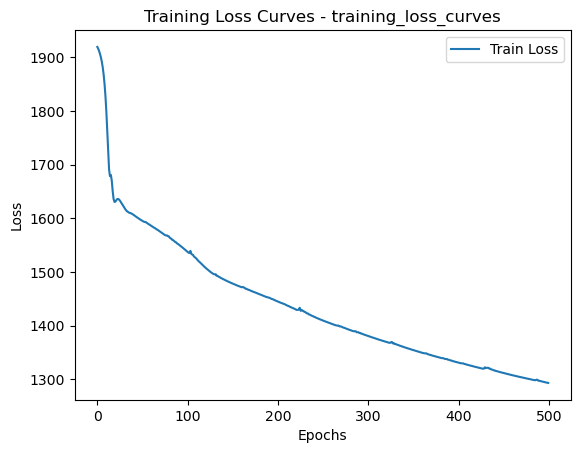

In [14]:
from utils import criterion

# You will have to play around with this a LOT!!! For some reason, it works better on CUDA than MPS.
STYLE_LOSS_PARAM = 100

your_train_dataset = dataList
train_loader = DataLoader(your_train_dataset, batch_size=1, shuffle=True)
# optimizer = Adam(list(model.parameters()) + [a_G_var], lr=1e-3)
optimizer = Adam(model.parameters(), lr=1e-4)
# optimizer.param_groups.append({'params': a_G_var })
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
criterion = criterion
filename = "training_loss_curves"
epochs = 500
# device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_and_plot(model, randomCNN, a_S, optimizer, scheduler, criterion, train_loader, filename, epochs, device, style_loss_param=STYLE_LOSS_PARAM)

In [26]:

input = dataList[0]
input = (input[0].clone().detach(), torch.from_numpy(input[1]).to(device))
input = (input[0].unsqueeze(0), input[1].unsqueeze(0))

model.eval()
with torch.no_grad():
    out = model.forward(input)
    decoder_output = out[2]
    postnet_output = out[3]
    out = postnet_output.to('cpu')
    print(out.shape)


tensor([[5.1899e+01, 2.3913e+00, 5.4084e+01,  ..., 1.9426e+00, 2.5350e+00,
         7.7238e+00],
        [3.2510e+01, 6.3745e+00, 4.0584e+01,  ..., 9.0176e+00, 1.3664e+01,
         1.0329e+01],
        [1.6414e+01, 2.2947e+00, 1.4541e+01,  ..., 6.8699e+00, 8.5702e+00,
         6.2364e+00],
        ...,
        [2.7260e-03, 4.5134e-11, 9.6634e-11,  ..., 9.3937e-11, 1.7426e-11,
         8.4871e-05],
        [2.7249e-03, 1.5724e-10, 1.3324e-10,  ..., 1.1680e-10, 9.1422e-11,
         8.4657e-05],
        [2.7253e-03, 3.0085e-10, 6.5711e-11,  ..., 5.1159e-11, 8.4256e-11,
         8.4688e-05]])


TypeError: expected np.ndarray (got Tensor)

In [19]:
import torch
import numpy as np
import os
import soundfile as sf
from Vocoder import Vocoder

# Example batch of magnitude spectrograms of shape (N, 80, T)
N = 1  # Number of samples in the batch
T = 80  # Number of time bins
# magnitude_spectrogram_batch = torch.rand(N, 201, 2206)

# Instantiate Vocoder
vocoder = Vocoder(n_fft=n_ftt, hop_length=hop_length, win_length=win_length, num_iters=200)

# Output directory to save reconstructed waveforms
output_dir = "output_waveforms"

# Reconstruct waveforms from the batch of magnitude spectrograms
# print(magnitude_spectrogram_batch.shape)
# spectrograms = torch.tensor(spectrograms).transpose(1, 2)
# print(spectrograms.shape)
reconstructed_waveforms = vocoder.reconstruct(out, output_dir, sample_rate=samplerate)

# Print the shape of the reconstructed waveforms
print(reconstructed_waveforms.shape)

torch.Size([1, 440895])
